In [1]:
import glob
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import geometry_mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score,
    confusion_matrix, classification_report, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [3]:
# Function to calculate and print class distribution
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Function to calculate and print class distribution by island
def print_class_distribution_by_island(df, name):
    class_counts = df.groupby(['image_name', 'encoded_labels']).size().unstack(fill_value=0)
    class_counts = class_counts.reset_index()
    class_counts['island'] = class_counts['image_name'].apply(lambda x: extract_island_and_date(x)[0])
    print(f"\n{name} Class Distribution by Island:")
    print(class_counts)

# Ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df


In [4]:
# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Print class distributions before applying class weights
print_class_distribution(train_df, "Training Before Class Weights")
print_class_distribution(test_df, "Test")


Training Before Class Weights Class Distribution:
ocean: 623431
ice: 240185
rock: 74284
freshwater: 32201
walrus_mixed: 657
walrus_pure: 38

Test Class Distribution:
ocean: 155857
ice: 60046
rock: 18572
freshwater: 8050
walrus_mixed: 165
walrus_pure: 10



Class Distribution Before Class Weights:
                       Class  Pixel Count
encoded_labels                           
0                 freshwater        32201
1                        ice       240185
2                      ocean       623431
3                       rock        74284
4               walrus_mixed          657
5                walrus_pure           38


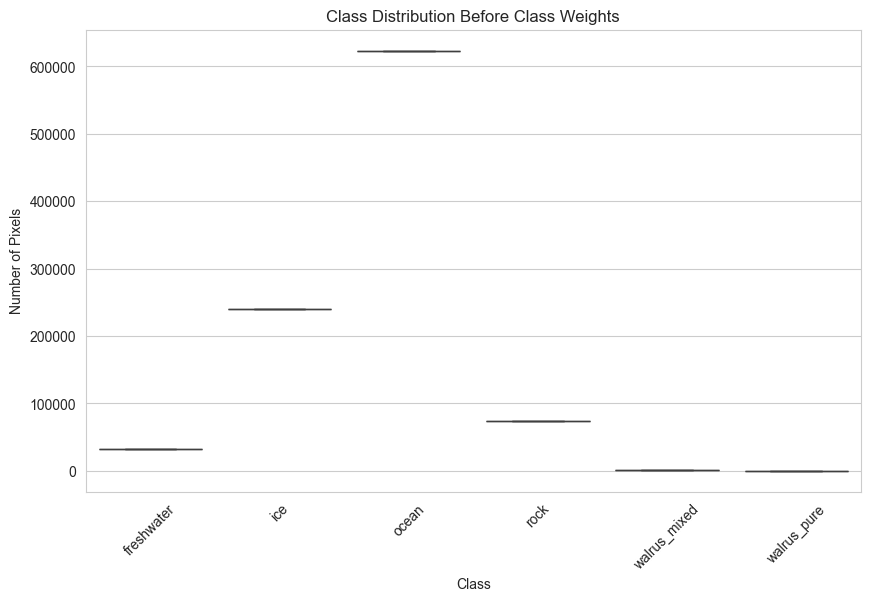

In [6]:
# Class distribution table and boxplot before applying class weights
class_counts_before_weights = train_df['encoded_labels'].value_counts().sort_index()
class_names_before_weights = le.inverse_transform(class_counts_before_weights.index)
distribution_df_before_weights = pd.DataFrame({'Class': class_names_before_weights, 'Pixel Count': class_counts_before_weights})

print("\nClass Distribution Before Class Weights:")
print(distribution_df_before_weights)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Pixel Count', data=distribution_df_before_weights)
plt.title('Class Distribution Before Class Weights')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylabel('Number of Pixels')
plt.show()

In [6]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the Random Forest model using the class weights
model = RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 5.0246679709739865,
                                     1: 0.673644621160078,
                                     2: 0.25953045859659424,
                                     3: 2.178118212984402, 4: 246.2699137493658,
                                     5: 4257.877192982456},
                       random_state=42)

In [7]:
# Save the model
model_filename = "RF_allislands_ClassWeights.joblib"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred = model.predict(X_test)

In [7]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.988772146683148
Precision: 0.9886750723403176
Recall: 0.988772146683148
F1 Score: 0.9885704076264737
Cohen's Kappa: 0.9783576099559044

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.92      0.87      0.89      8050
         ice       0.97      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155857
        rock       0.98      0.97      0.97     18572
walrus_mixed       0.92      0.29      0.44       165
 walrus_pure       1.00      0.80      0.89        10

    accuracy                           0.99    242700
   macro avg       0.97      0.82      0.86    242700
weighted avg       0.99      0.99      0.99    242700


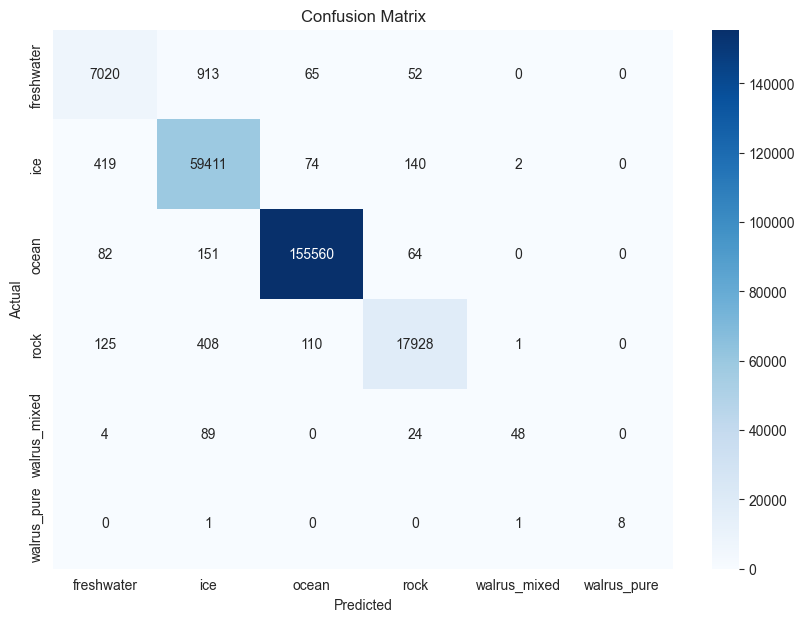

In [8]:
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


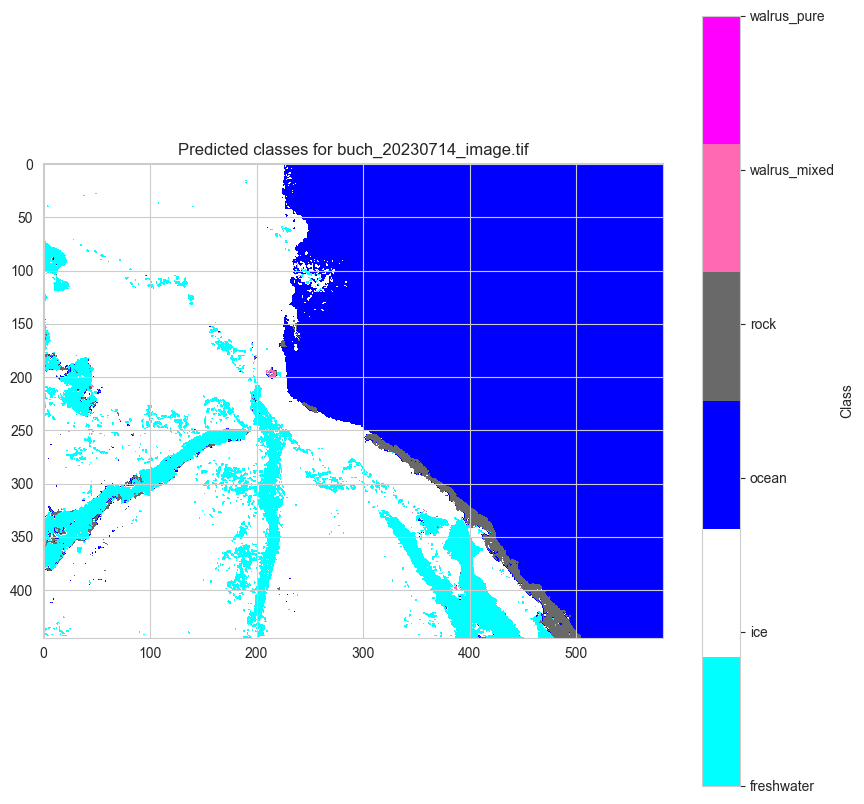

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


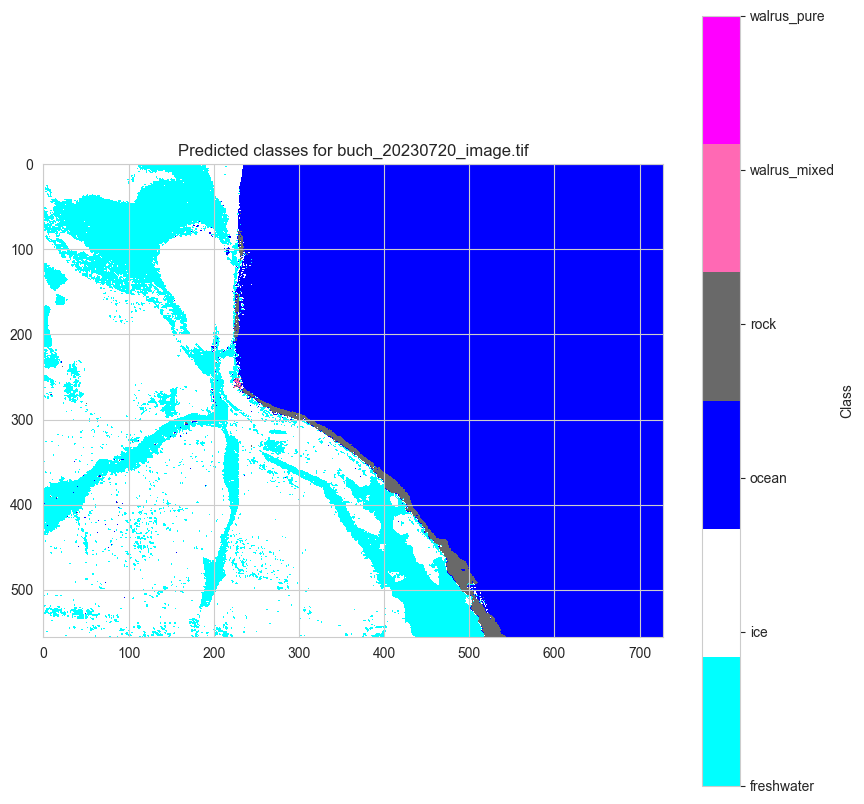

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


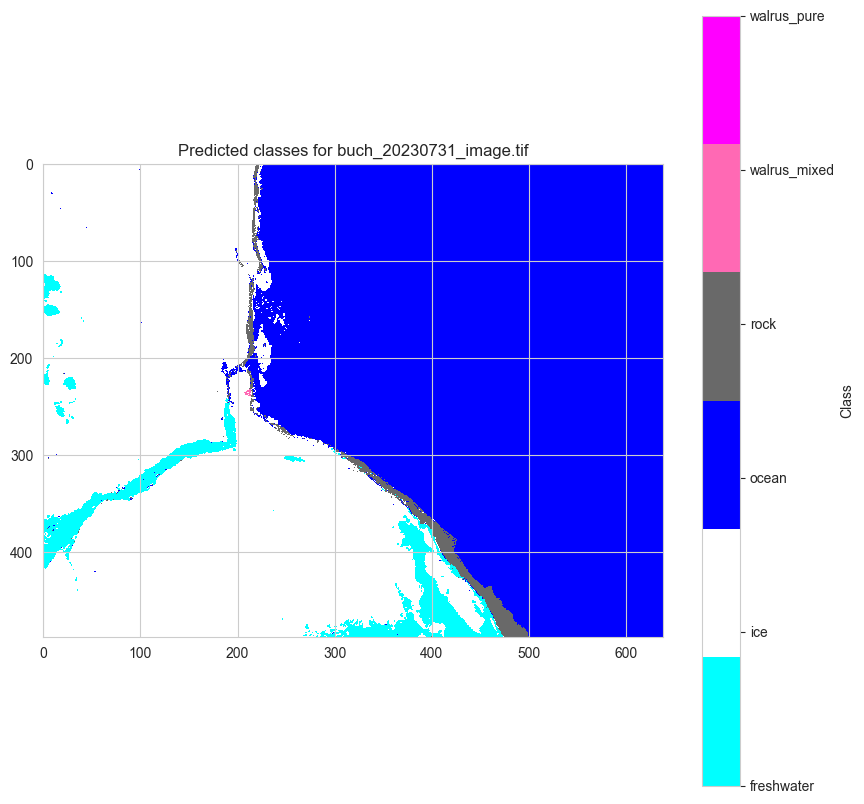

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


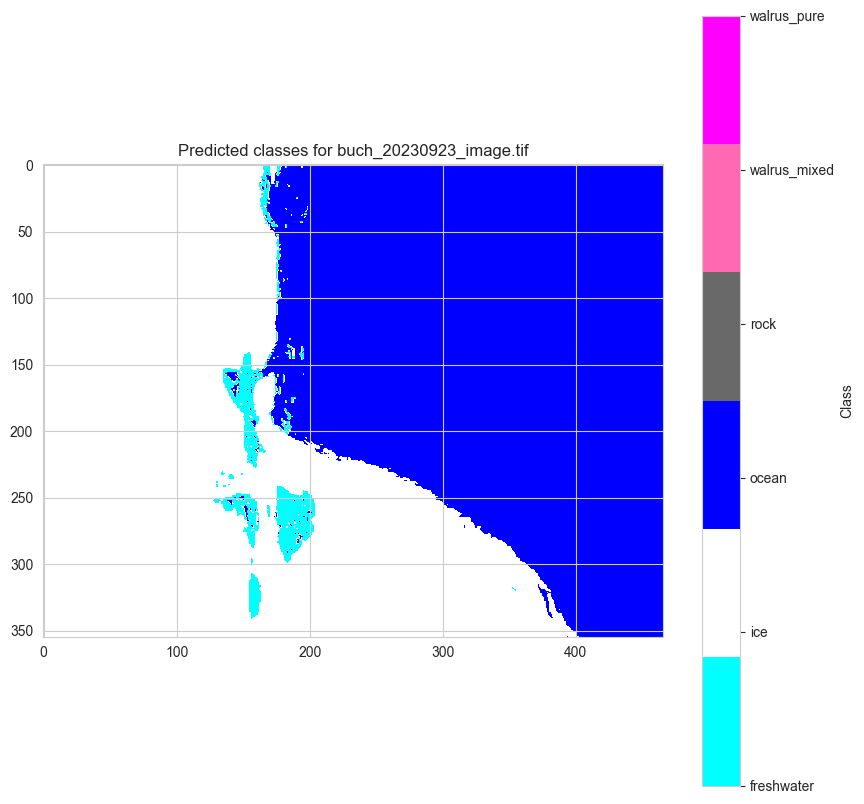

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


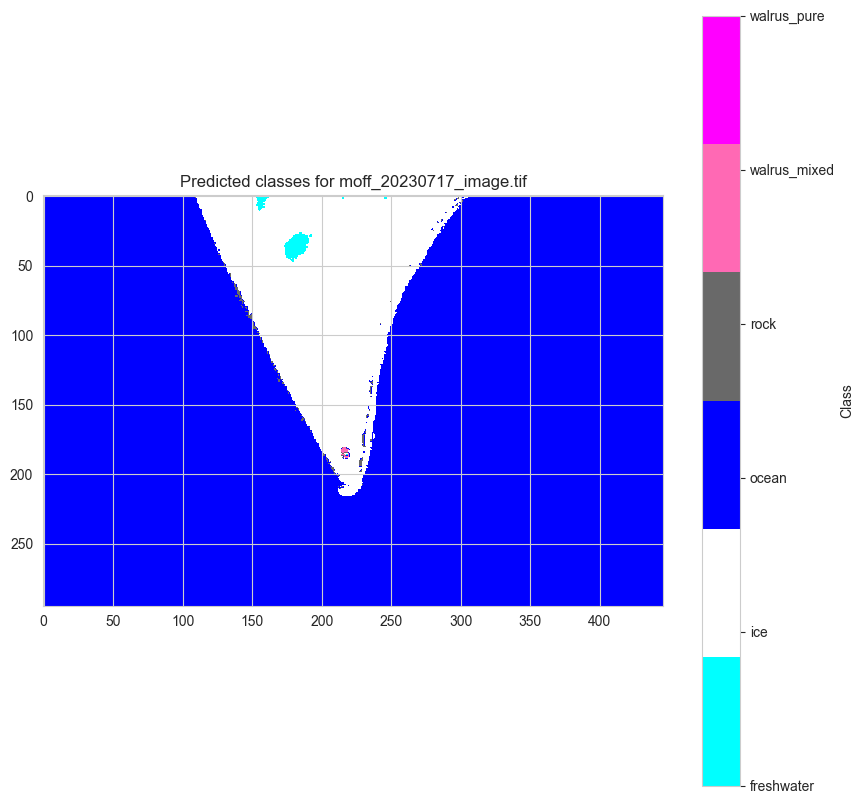

Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


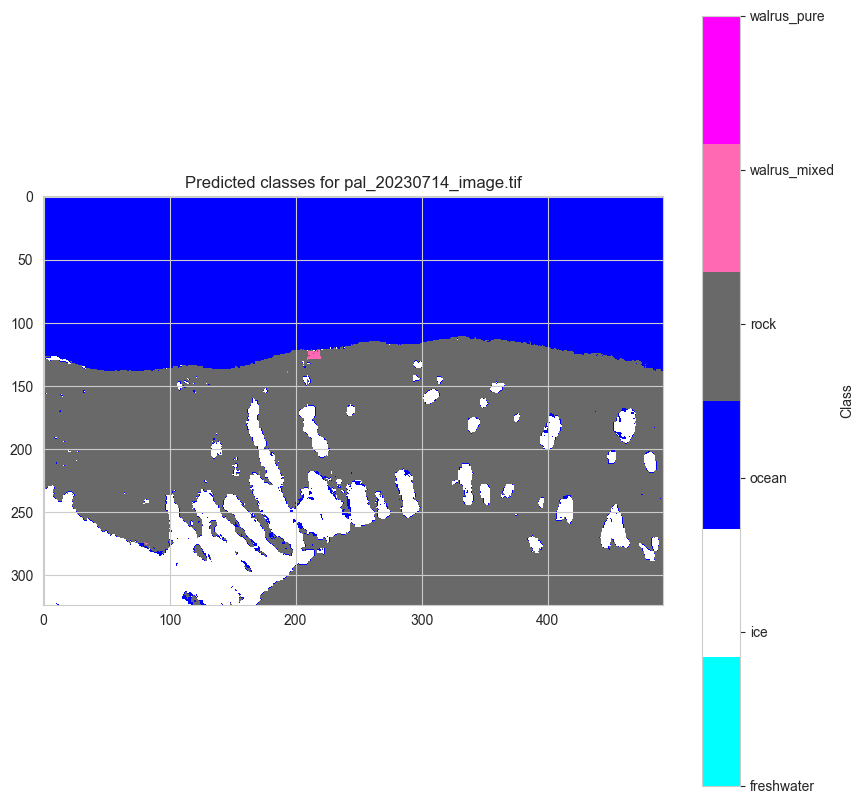

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


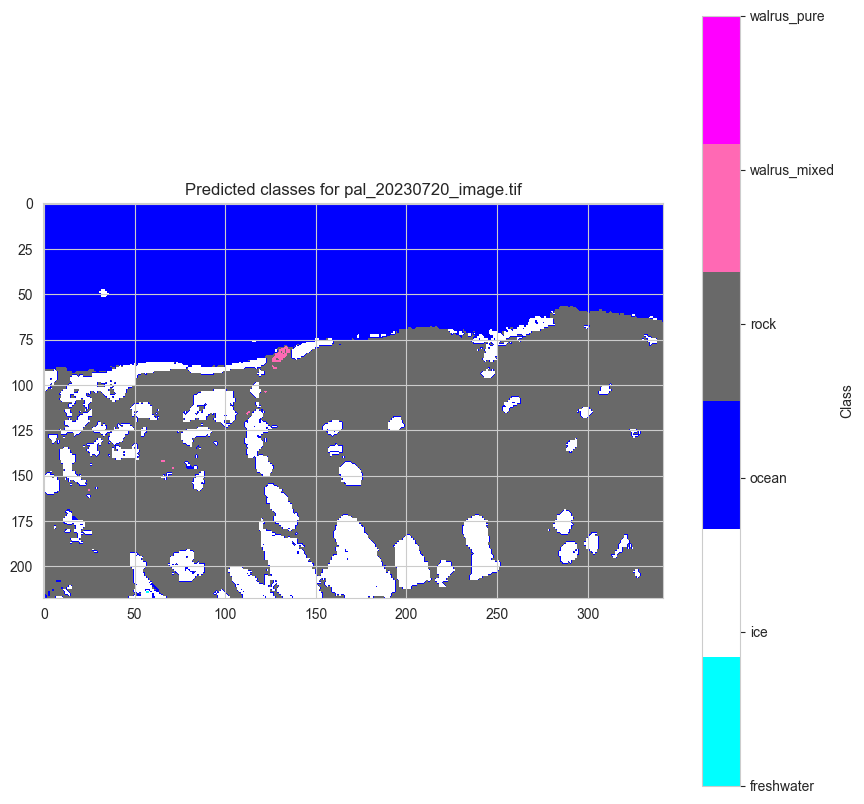

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


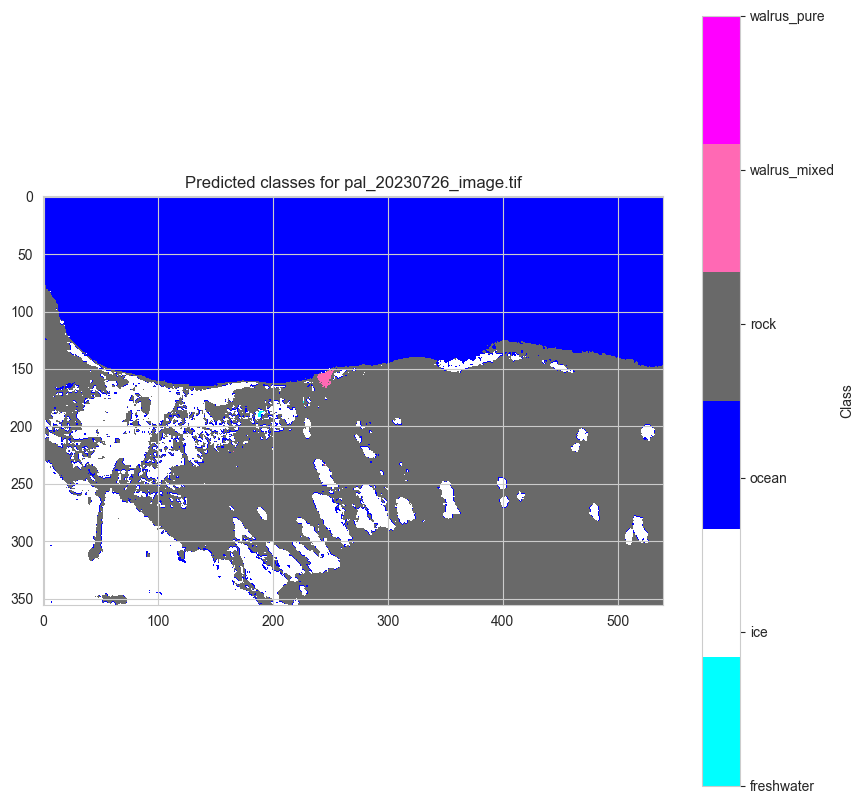

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


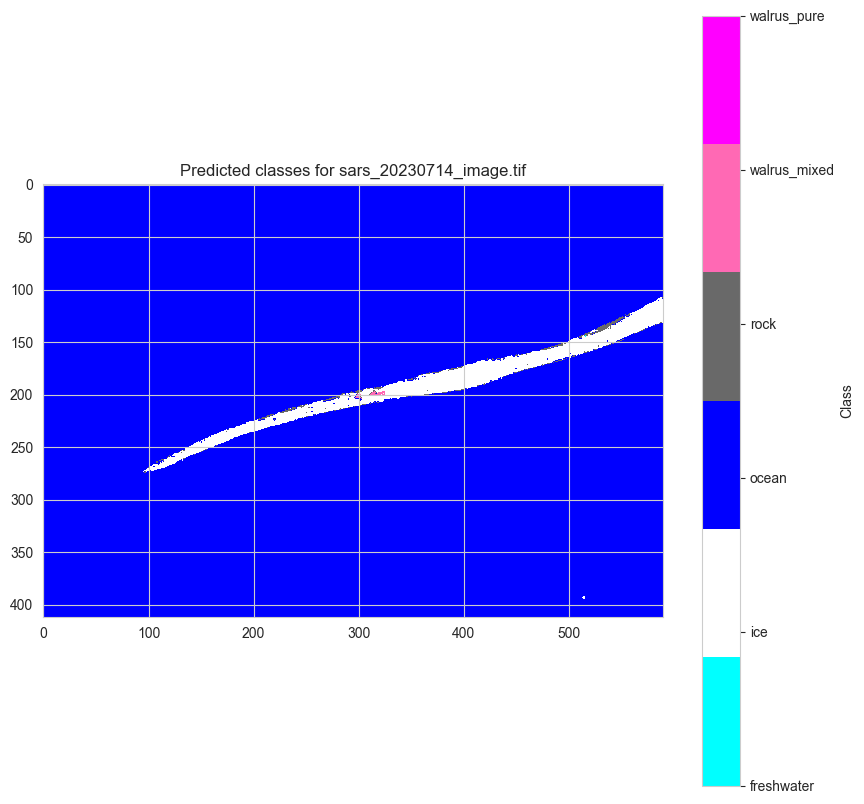

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


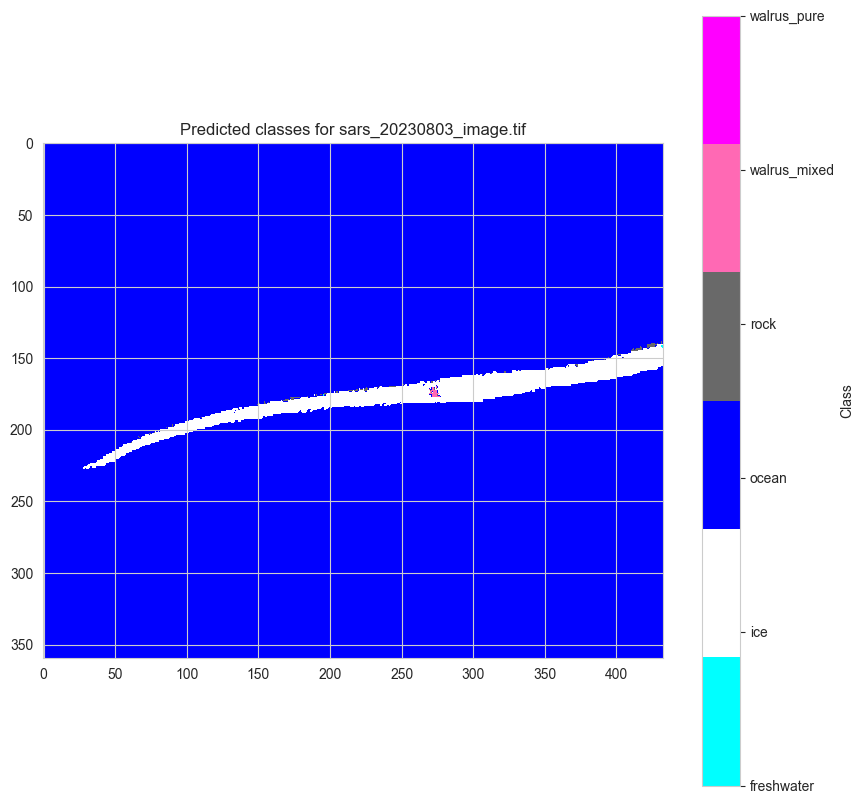

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


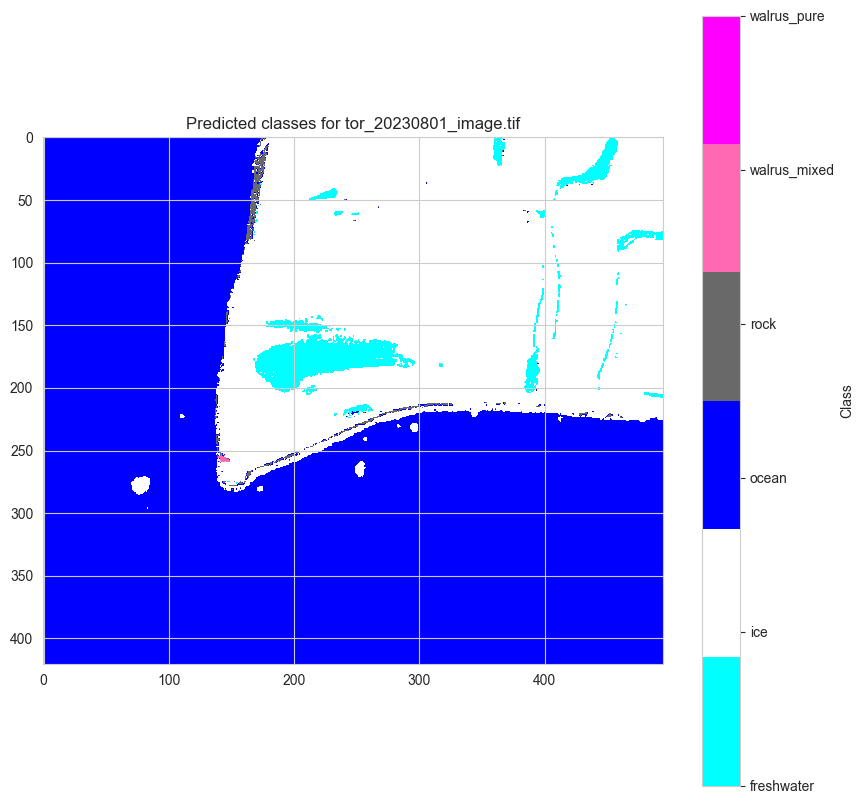

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


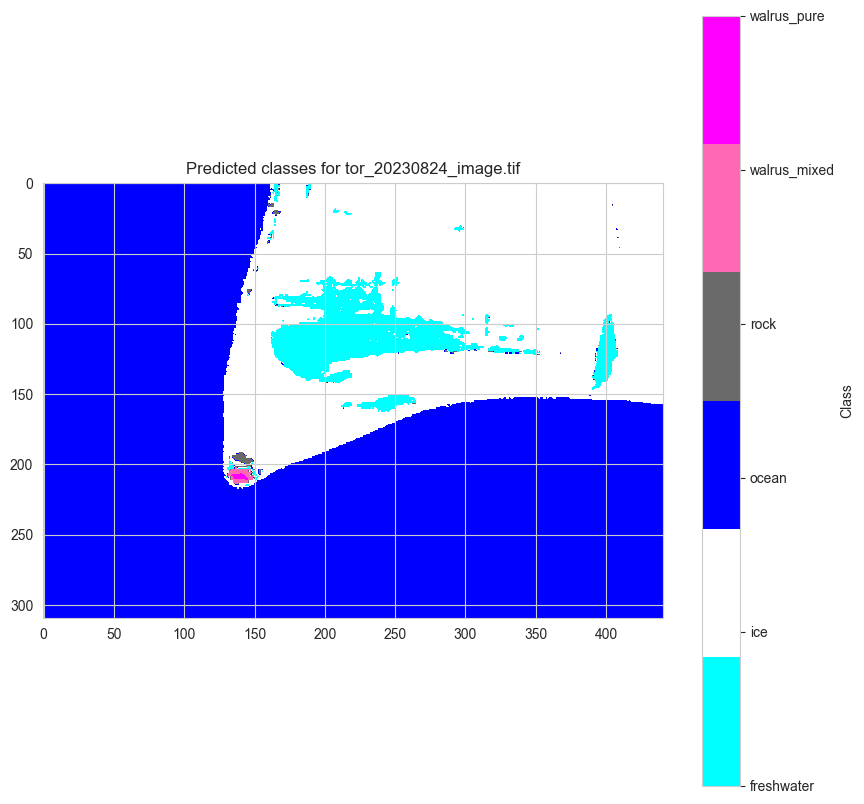

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


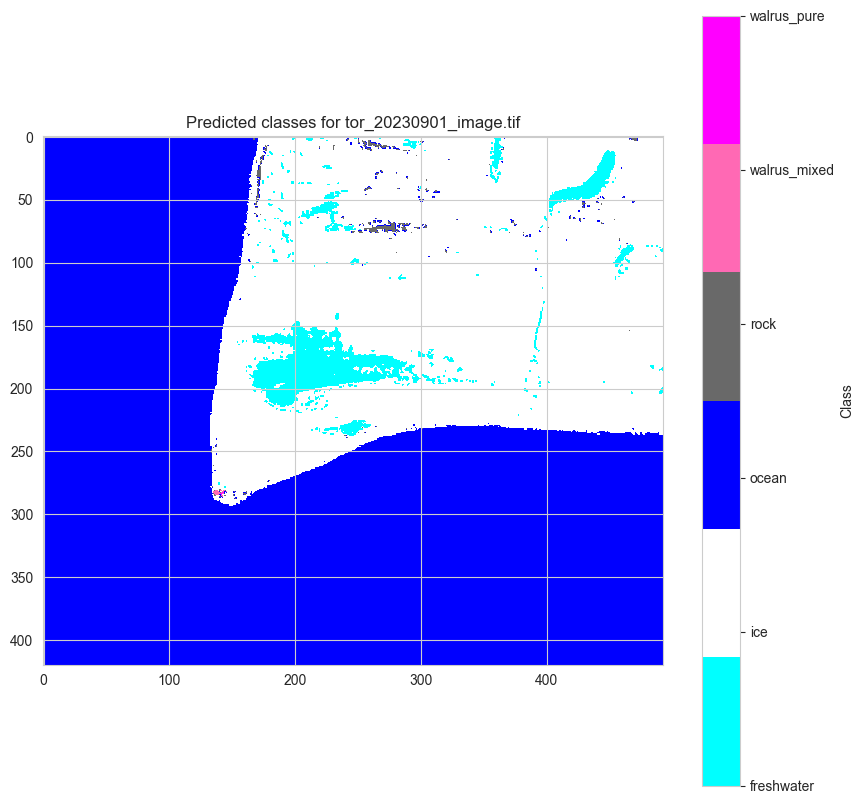

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


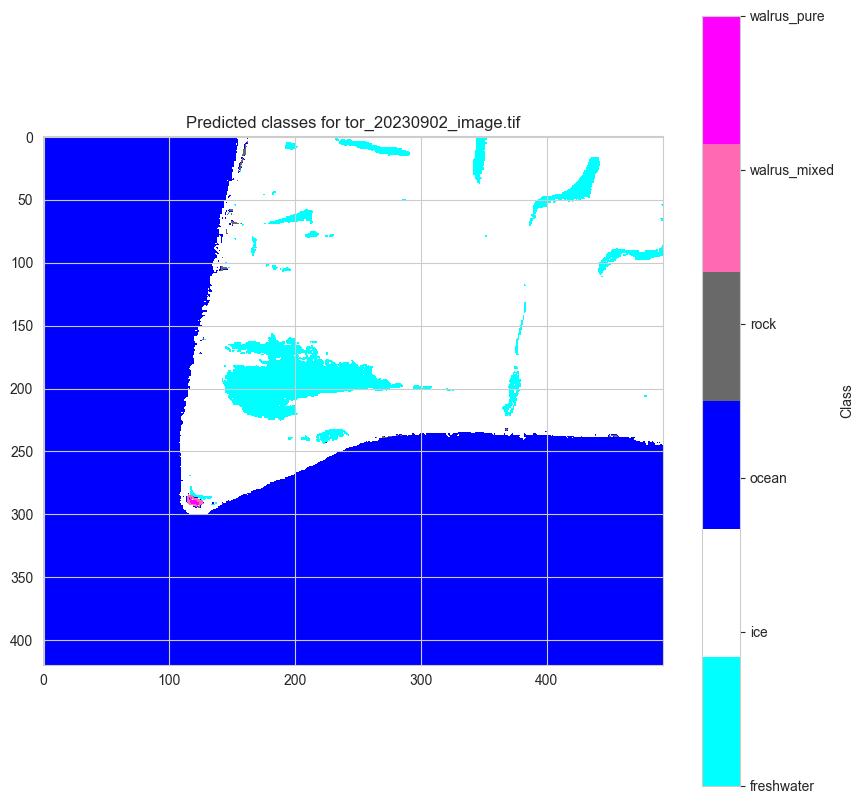

In [8]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

In [11]:
# Function to plot predictions
def plot_predictions(predicted_images, title):
    for image_path, predicted_image in predicted_images.items():
        unique_labels = np.unique(predicted_image)
        plt.figure(figsize=(10, 10))
        plt.title(f"{title} for {os.path.basename(image_path)}")
        plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

        cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
        cbar.ax.set_yticklabels(le.classes_)

        present_labels = [le.classes_[i] for i in unique_labels]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
        plt.show()


Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


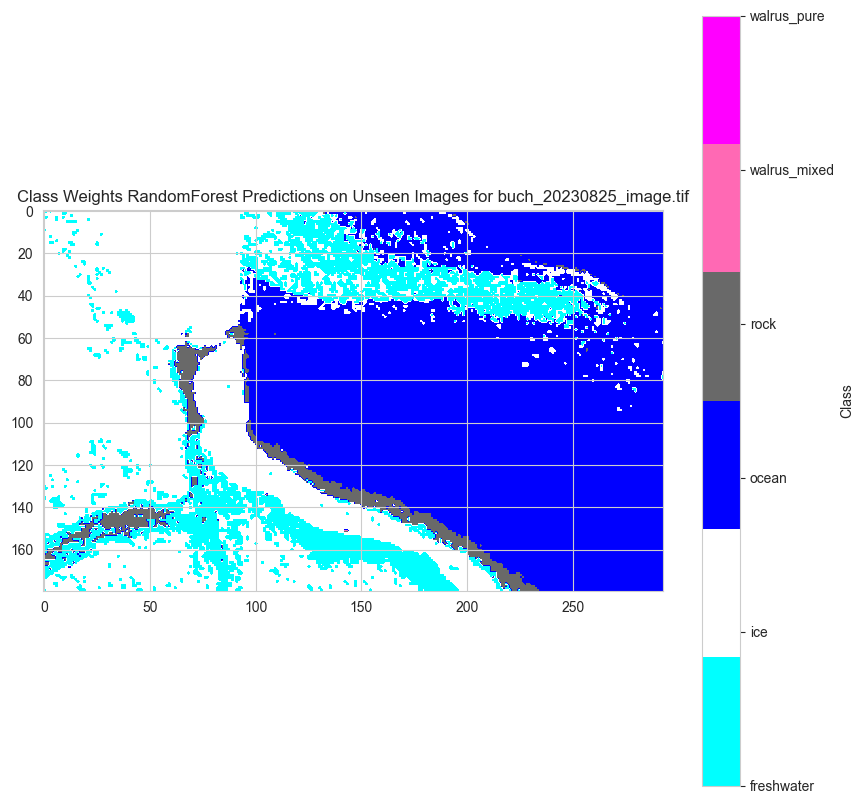

Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


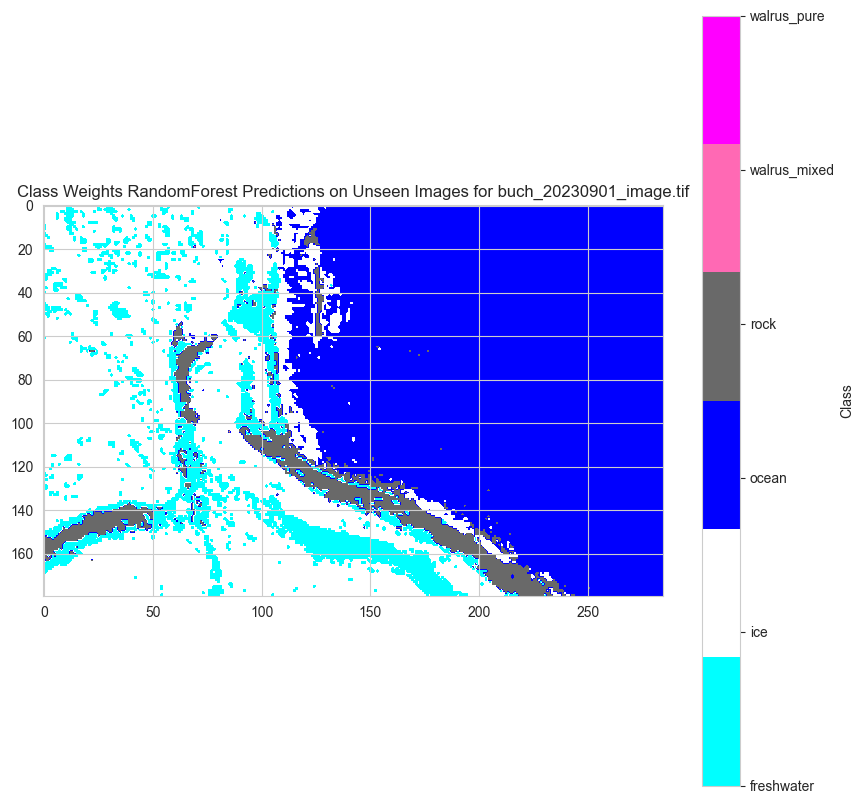

Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


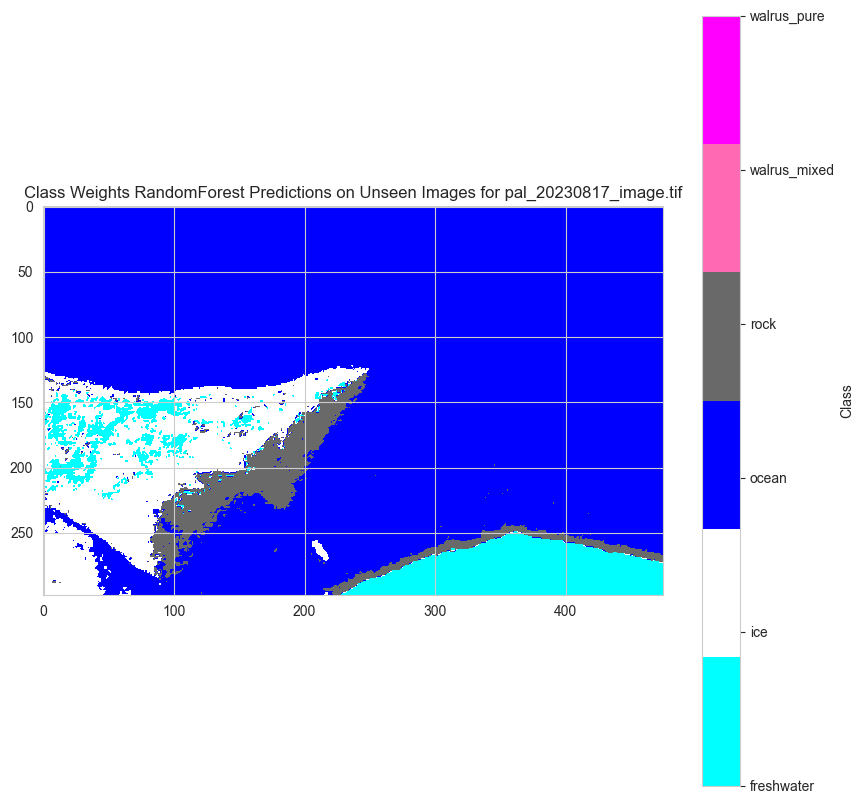

Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


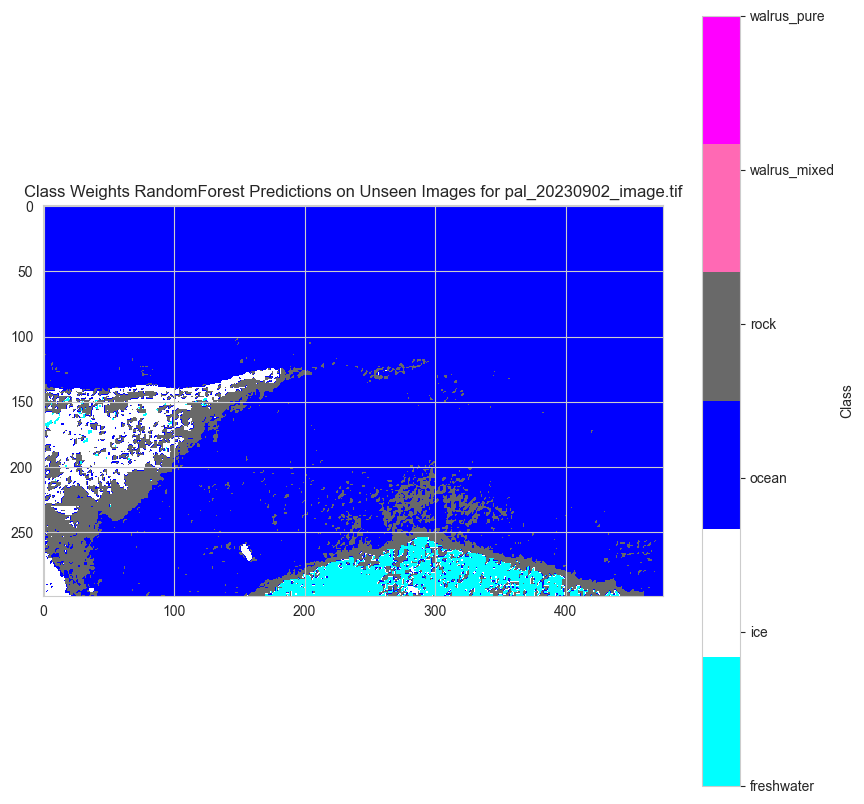

Labels present in sars_20230719_image.tif: ['ice', 'ocean', 'rock']


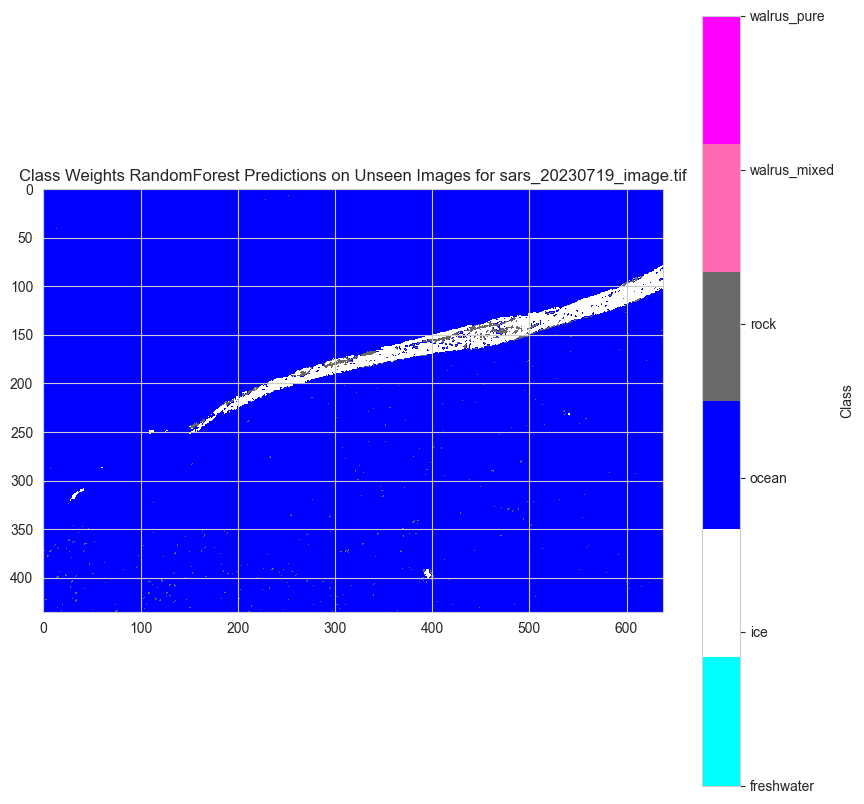

Labels present in sars_20230726.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


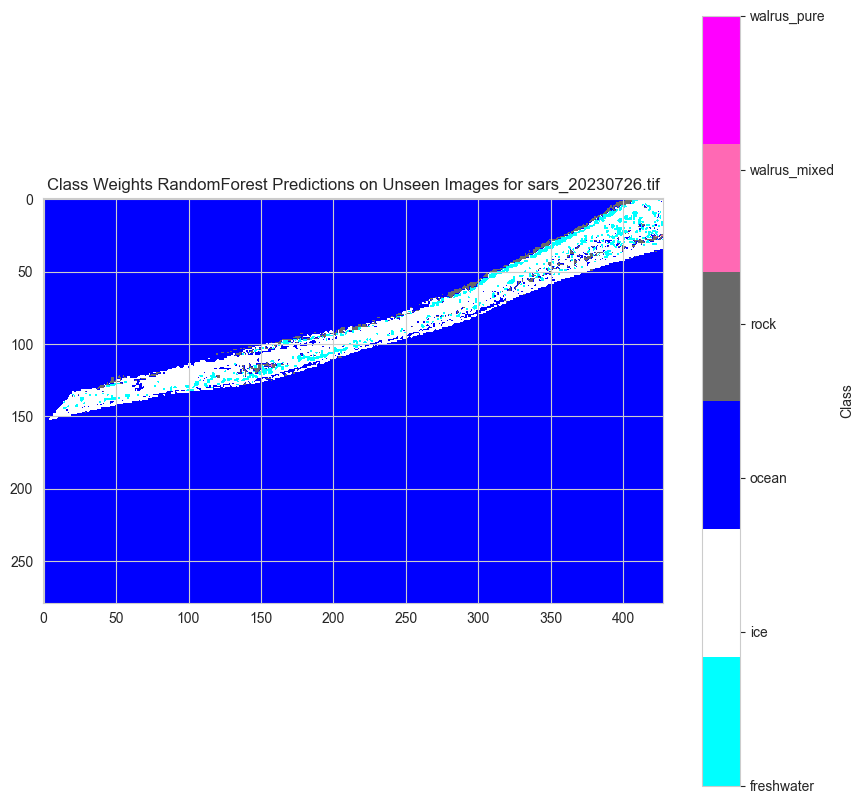

Labels present in sars_20230808_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


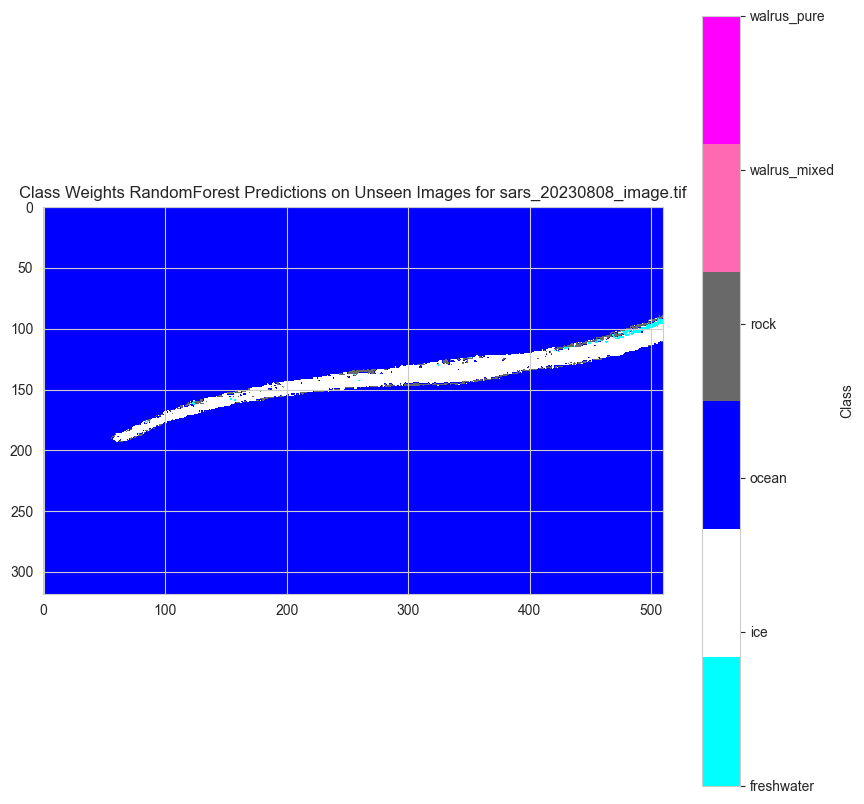

Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


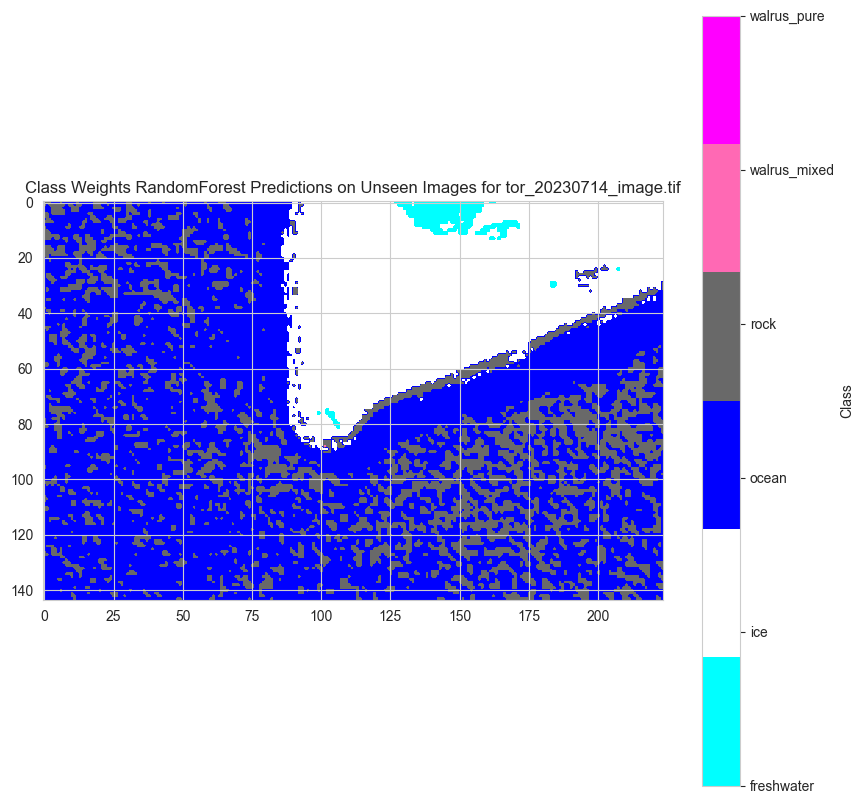

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


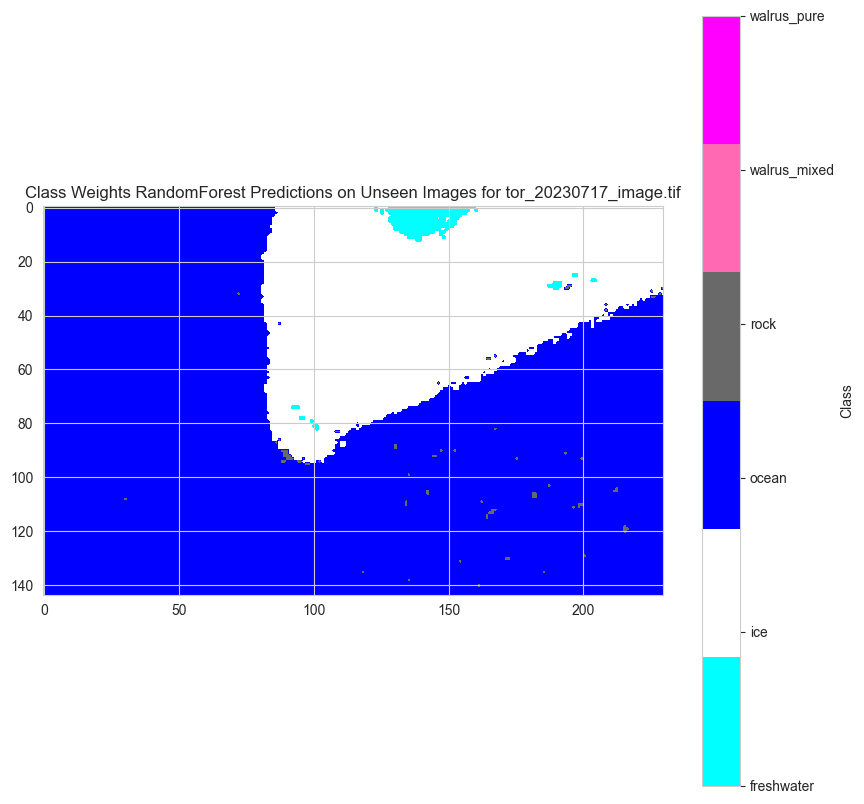

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


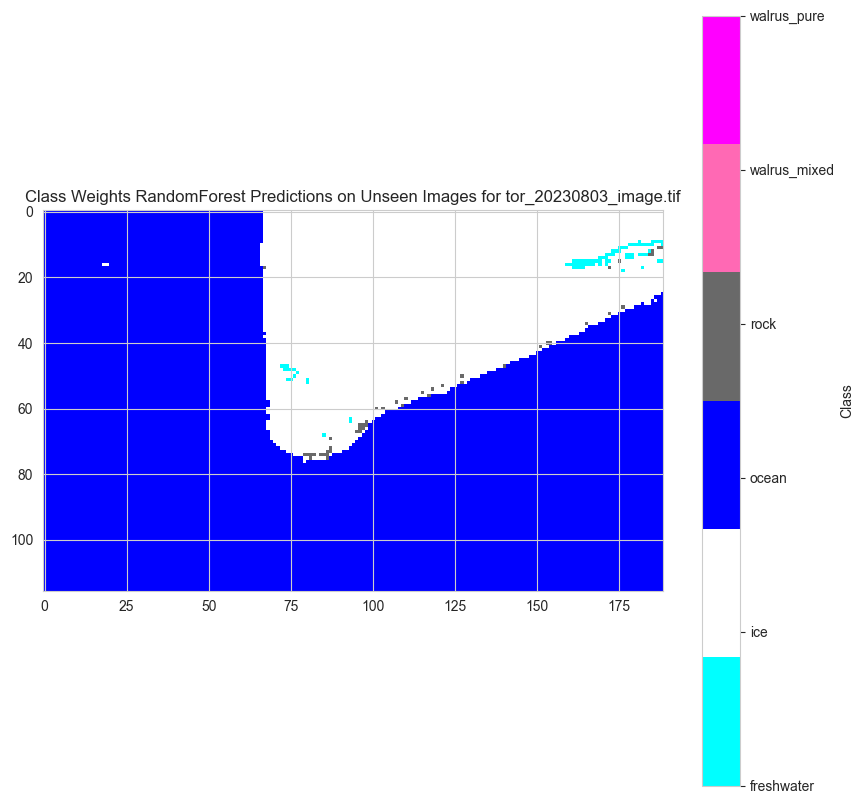

Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


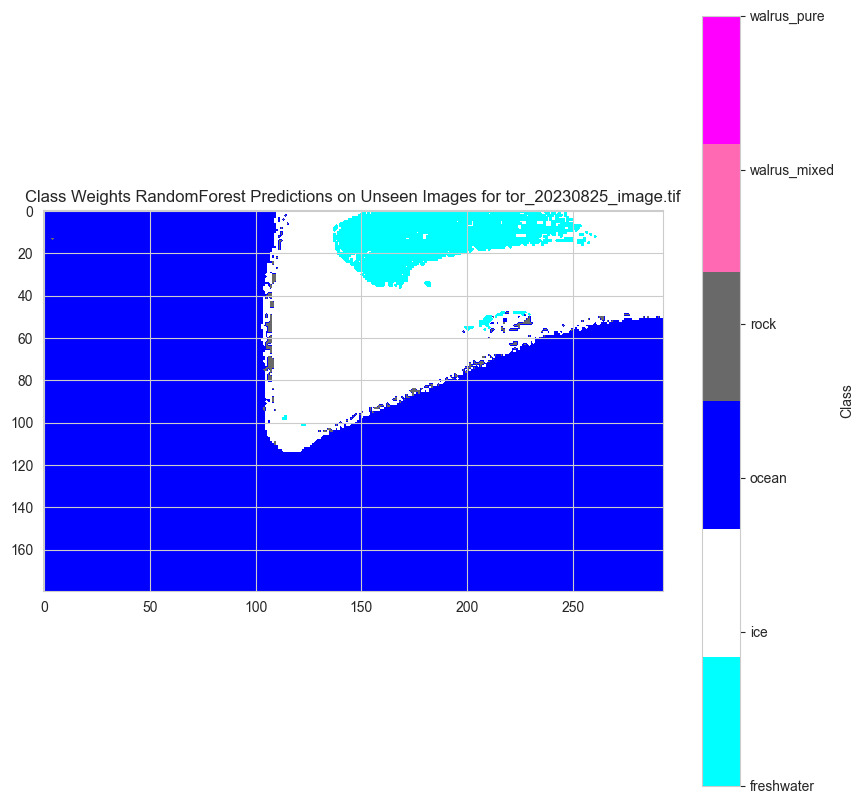

Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


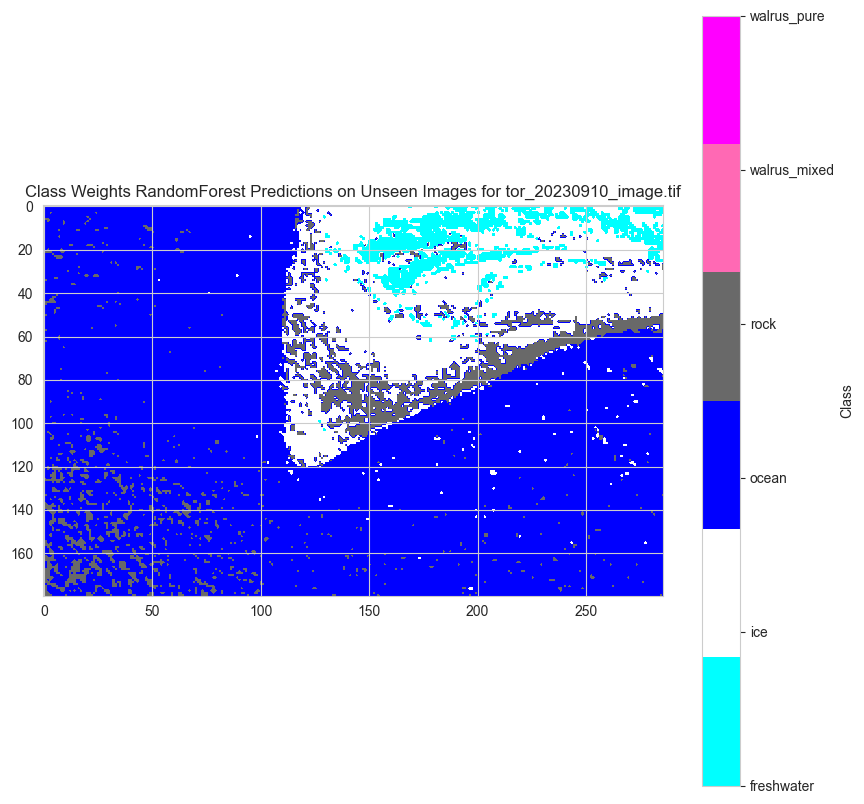

In [12]:
# Predict and plot results for unseen images
predicted_images_unseen_rf = {}
for image_path in unlabeled_image_paths:
    predicted_images_unseen_rf[image_path] = predict_image(image_path, model)

plot_predictions(predicted_images_unseen_rf, "Class Weights RandomForest Predictions on Unseen Images")


BALANCED WEIGHTS 

In [ ]:
import glob
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import geometry_mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score,
    confusion_matrix, classification_report, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [ ]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


In [13]:
# Function to calculate and print class distribution
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Function to calculate and print class distribution by island
def print_class_distribution_by_island(df, name):
    class_counts = df.groupby(['image_name', 'encoded_labels']).size().unstack(fill_value=0)
    class_counts = class_counts.reset_index()
    class_counts['island'] = class_counts['image_name'].apply(lambda x: extract_island_and_date(x)[0])
    print(f"\n{name} Class Distribution by Island:")
    print(class_counts)

# Ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df


In [14]:
# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Print class distributions before applying class weights
print_class_distribution(train_df, "Training Before Class Weights")
print_class_distribution(test_df, "Test")


Training Before Class Weights Class Distribution:
ocean: 623431
ice: 240185
rock: 74284
freshwater: 32201
walrus_mixed: 657
walrus_pure: 38

Test Class Distribution:
ocean: 155857
ice: 60046
rock: 18572
freshwater: 8050
walrus_mixed: 165
walrus_pure: 10


In [ ]:
# Class distribution table and boxplot before applying class weights
class_counts_before_weights = train_df['encoded_labels'].value_counts().sort_index()
class_names_before_weights = le.inverse_transform(class_counts_before_weights.index)
distribution_df_before_weights = pd.DataFrame({'Class': class_names_before_weights, 'Pixel Count': class_counts_before_weights})

print("\nClass Distribution Before Class Weights:")
print(distribution_df_before_weights)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Pixel Count', data=distribution_df_before_weights)
plt.title('Class Distribution Before Class Weights')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylabel('Number of Pixels')
plt.show()

In [15]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the Random Forest model using the class weights
model = RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 5.0246679709739865,
                                     1: 0.673644621160078,
                                     2: 0.25953045859659424,
                                     3: 2.178118212984402, 4: 246.2699137493658,
                                     5: 4257.877192982456},
                       random_state=42)

In [17]:
# Save the model
model_filename = "RF_allislands_ClassWeights.joblib"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.988772146683148
Precision: 0.9886750723403176
Recall: 0.988772146683148
F1 Score: 0.9885704076264737
Cohen's Kappa: 0.9783576099559044

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.92      0.87      0.89      8050
         ice       0.97      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155857
        rock       0.98      0.97      0.97     18572
walrus_mixed       0.92      0.29      0.44       165
 walrus_pure       1.00      0.80      0.89        10

    accuracy                           0.99    242700
   macro avg       0.97      0.82      0.86    242700
weighted avg       0.99      0.99      0.99    242700


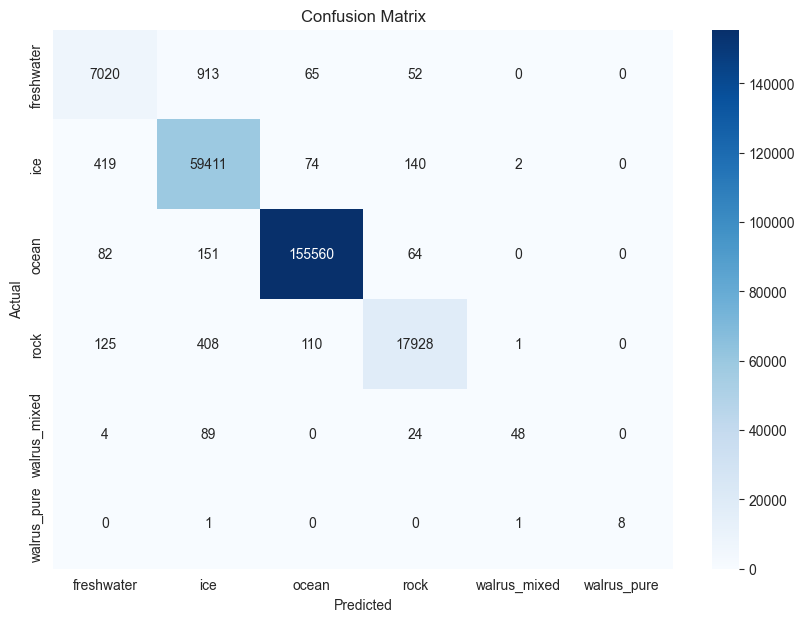

In [18]:
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


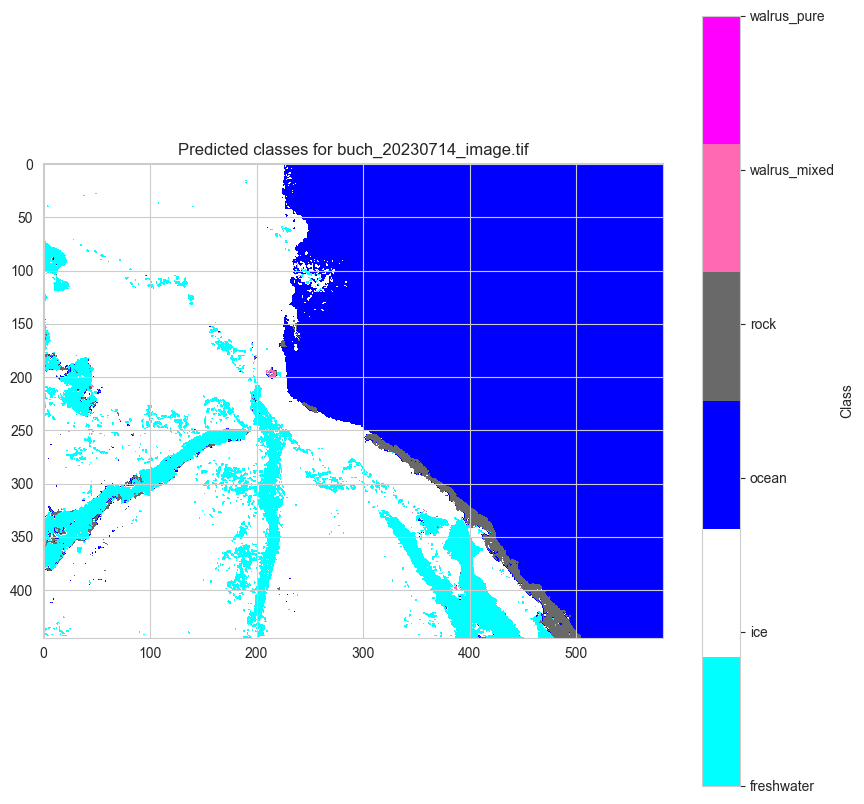

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


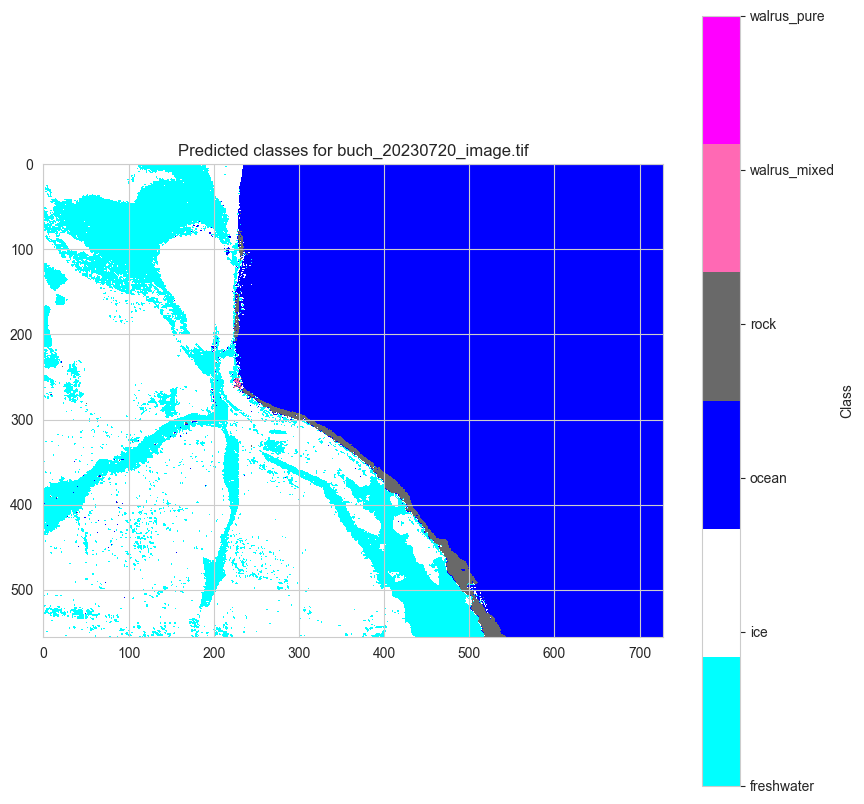

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


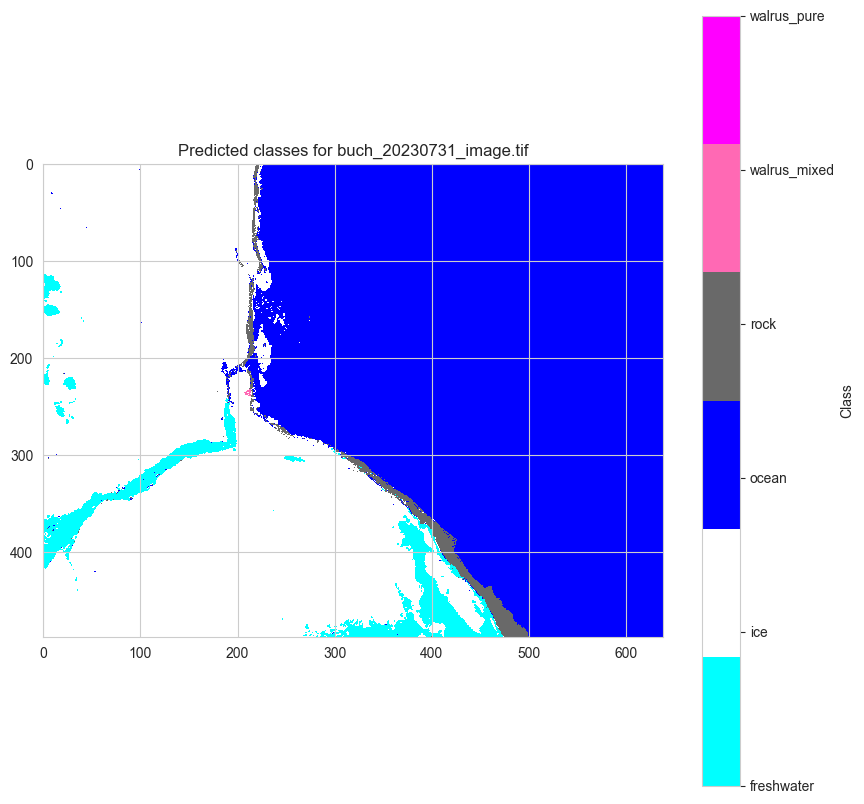

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


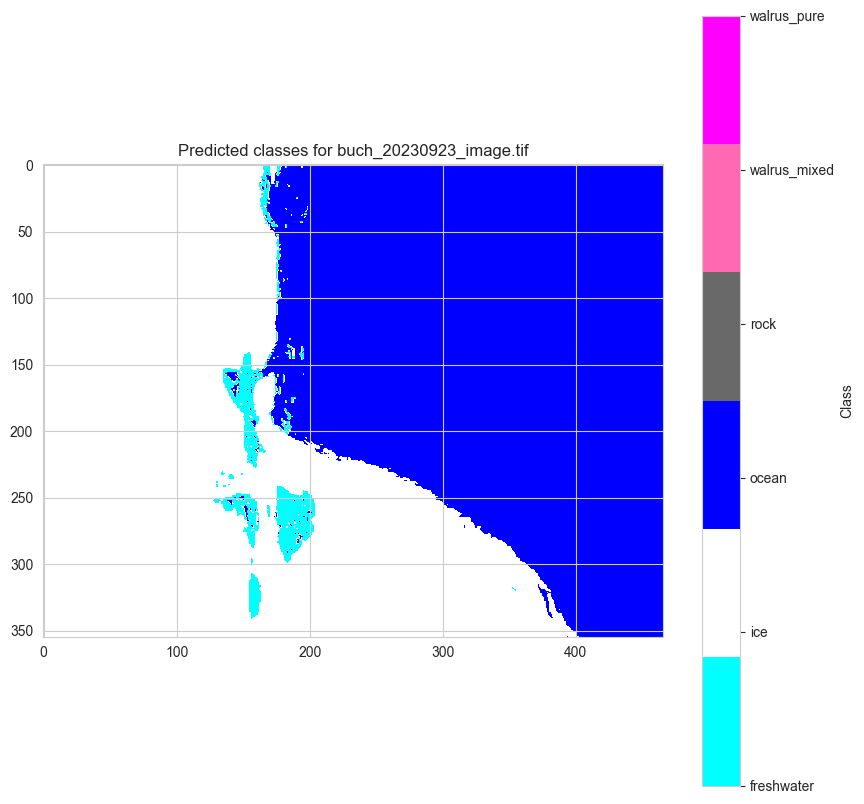

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


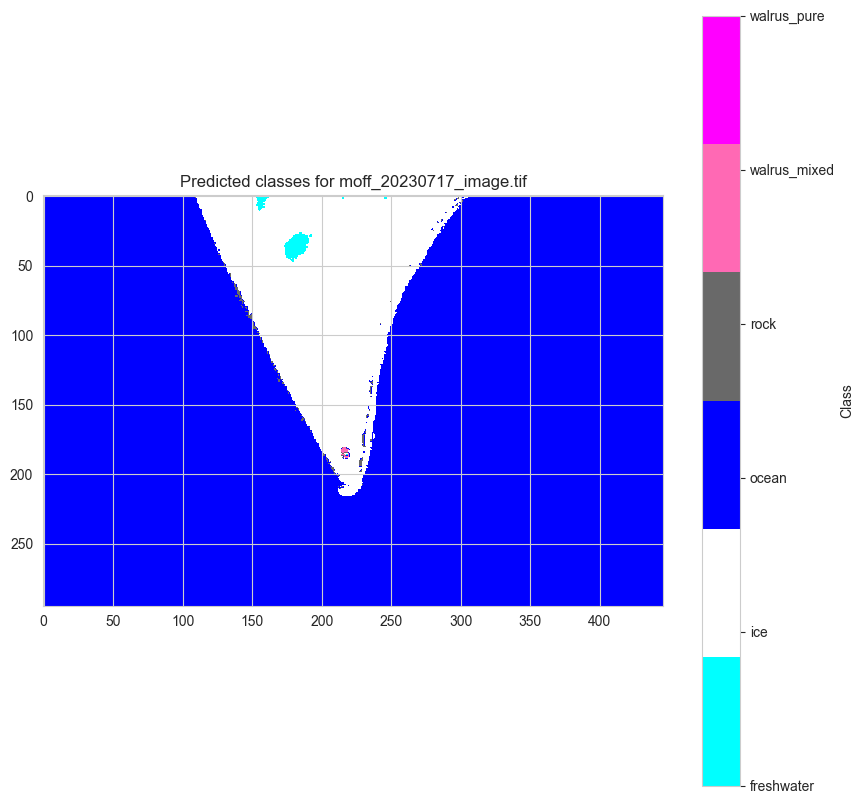

Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


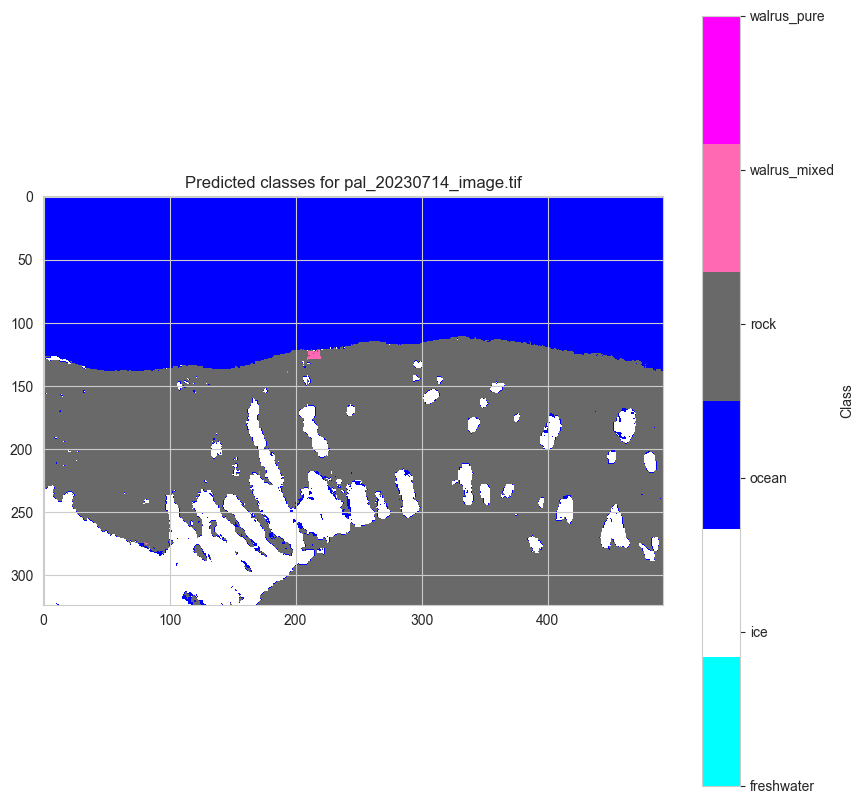

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


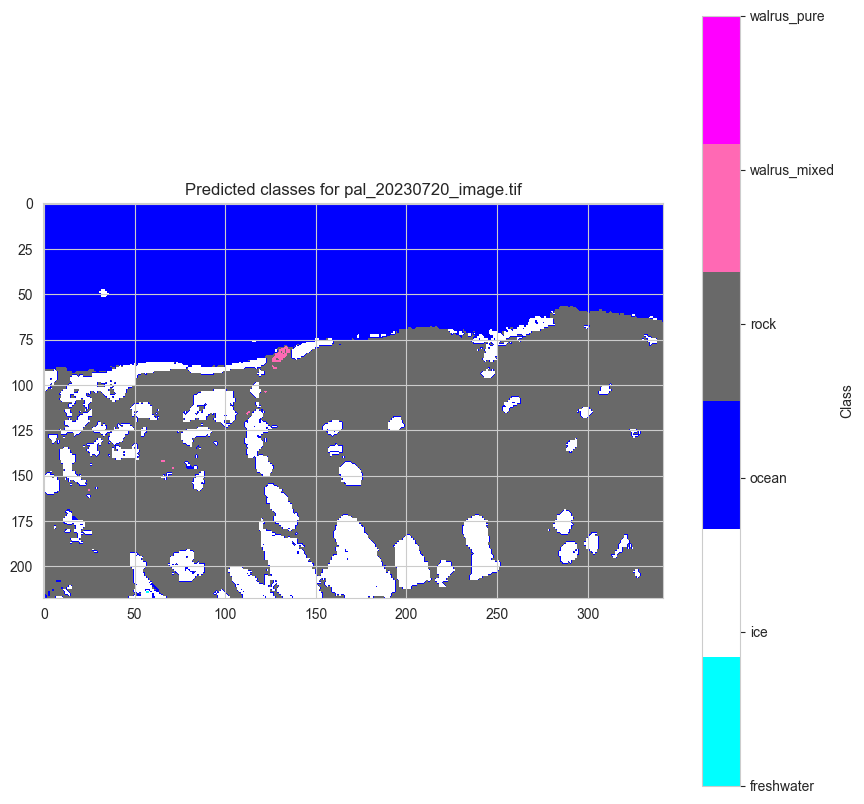

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


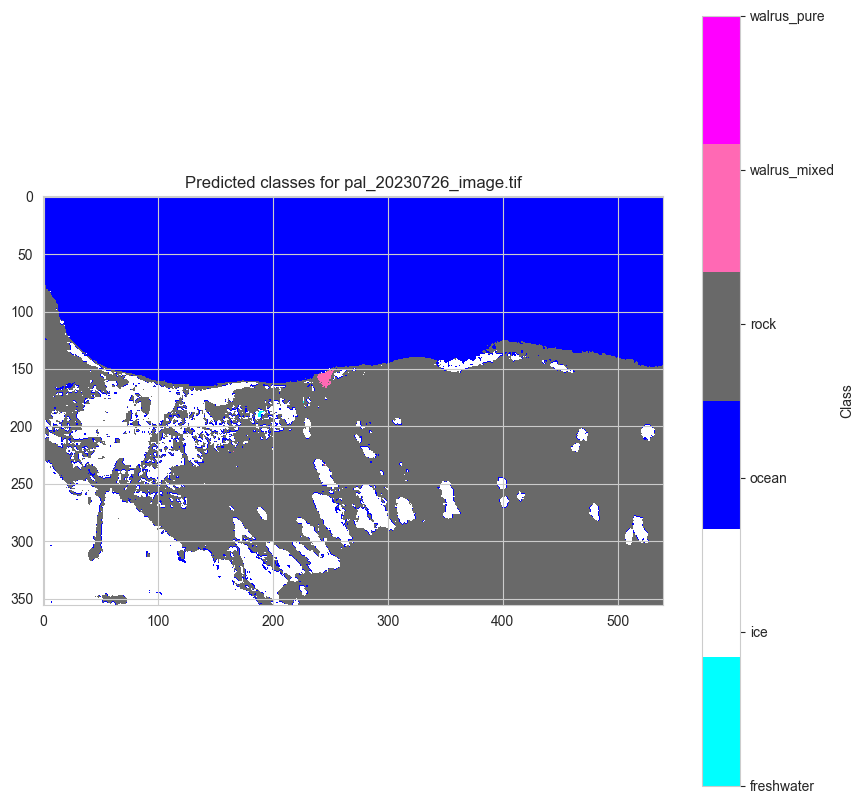

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


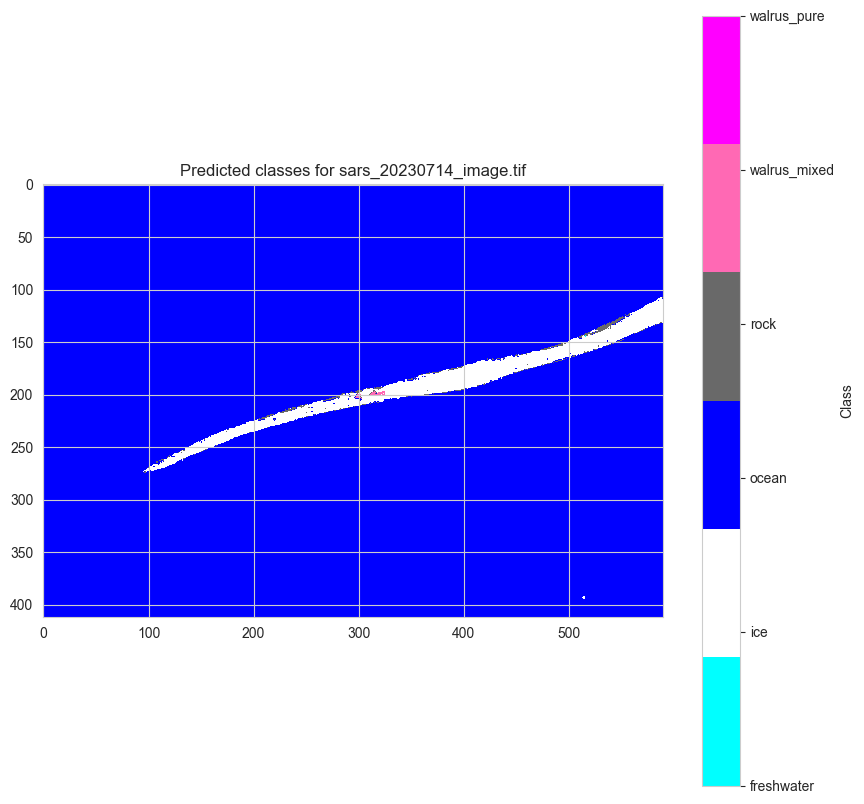

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


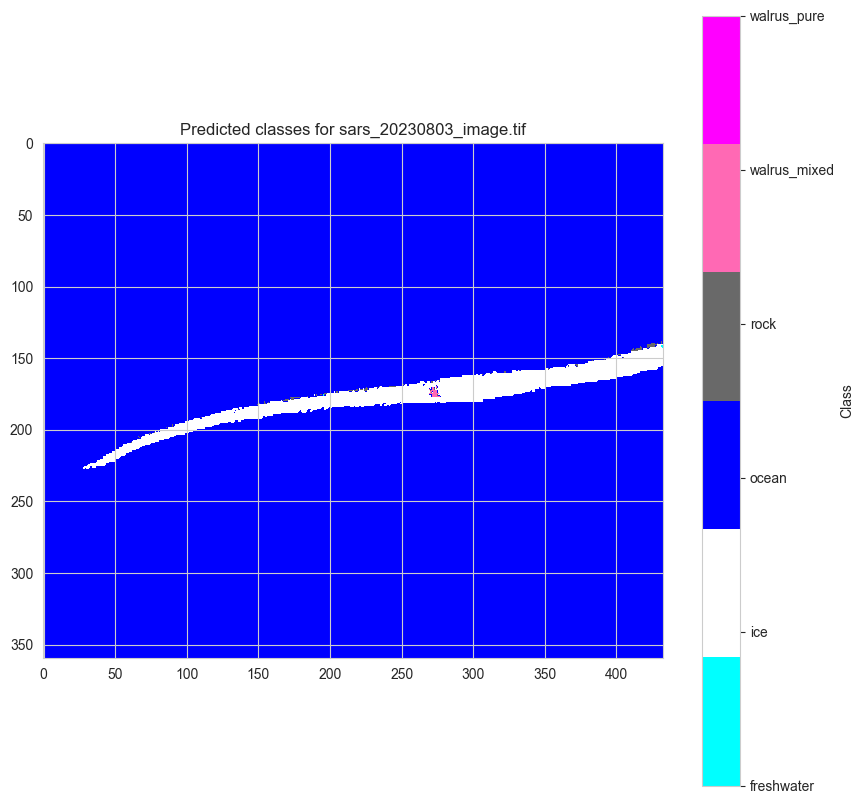

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


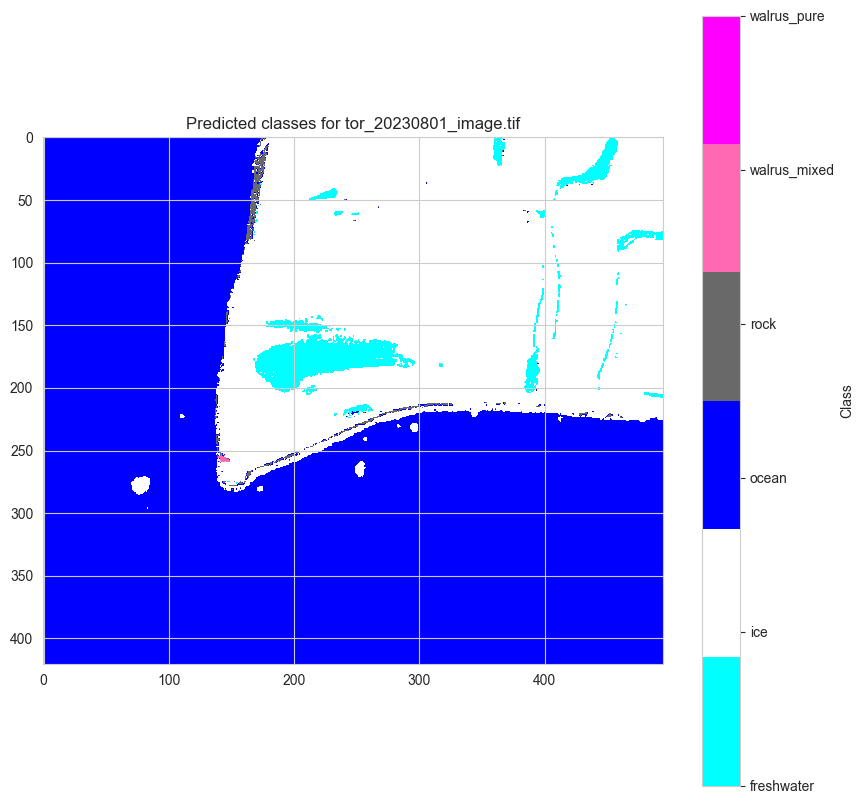

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


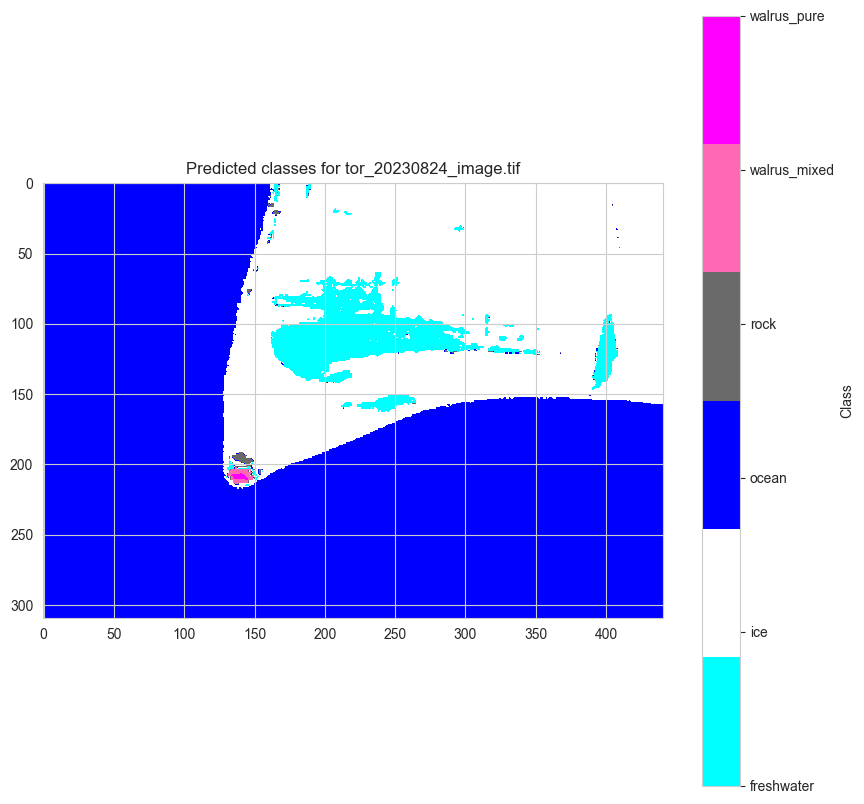

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


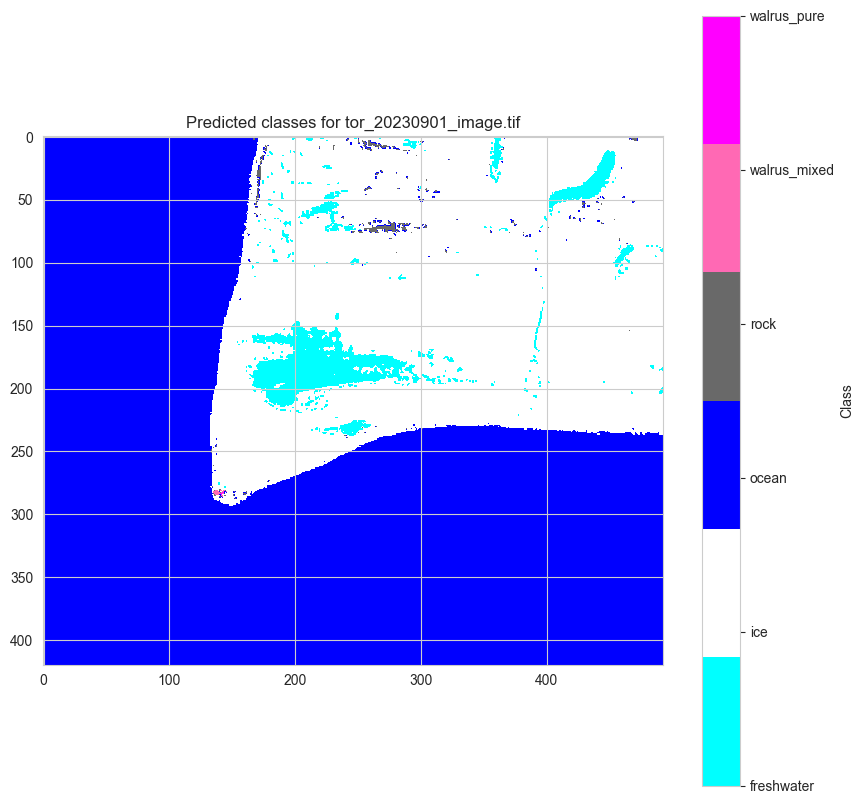

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


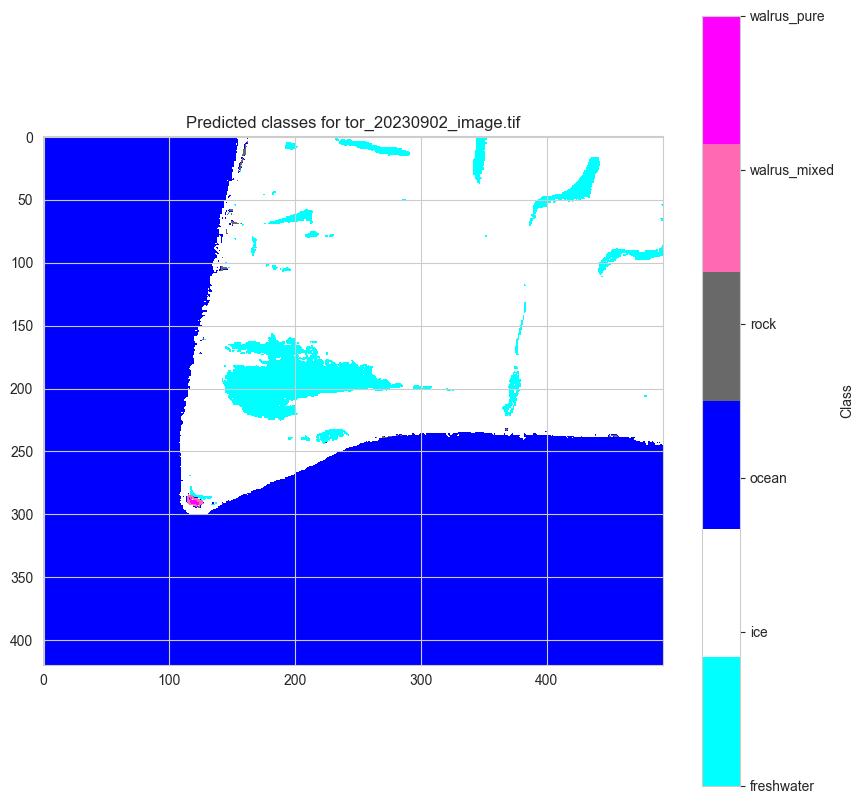

In [19]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))


predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink',
                'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_) - 1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels

    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

In [ ]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

# Function to plot predictions
def plot_predictions(predicted_images, title):
    for image_path, predicted_image in predicted_images.items():
        unique_labels = np.unique(predicted_image)
        plt.figure(figsize=(10, 10))
        plt.title(f"{title} for {os.path.basename(image_path)}")
        plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)

        cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
        cbar.ax.set_yticklabels(le.classes_)

        present_labels = [le.classes_[i] for i in unique_labels]
        print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
        plt.show()

Accuracy: 0.988772146683148
Precision: 0.9886750723403176
Recall: 0.988772146683148
F1 Score: 0.9885704076264737
Cohen's Kappa: 0.9783576099559044

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.92      0.87      0.89      8050
         ice       0.97      0.99      0.98     60046
       ocean       1.00      1.00      1.00    155857
        rock       0.98      0.97      0.97     18572
walrus_mixed       0.92      0.29      0.44       165
 walrus_pure       1.00      0.80      0.89        10

    accuracy                           0.99    242700
   macro avg       0.97      0.82      0.86    242700
weighted avg       0.99      0.99      0.99    242700


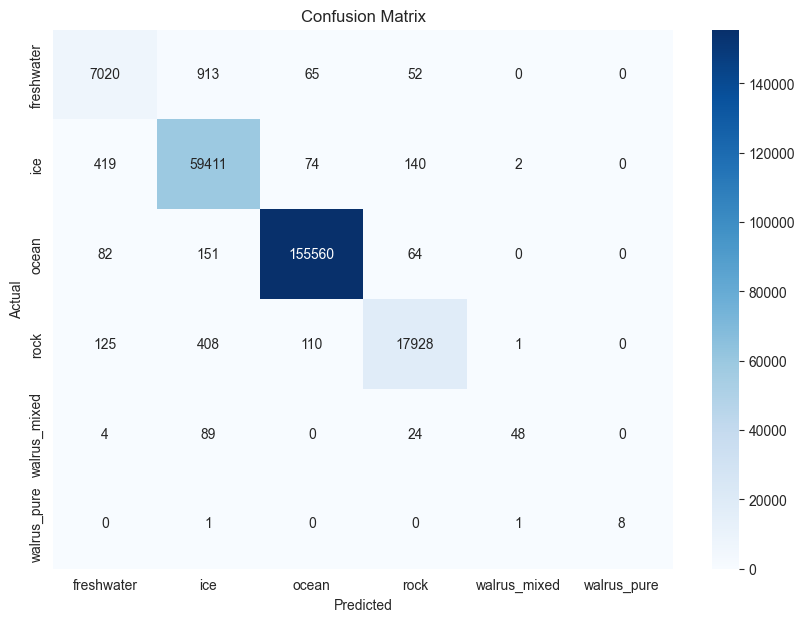

Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


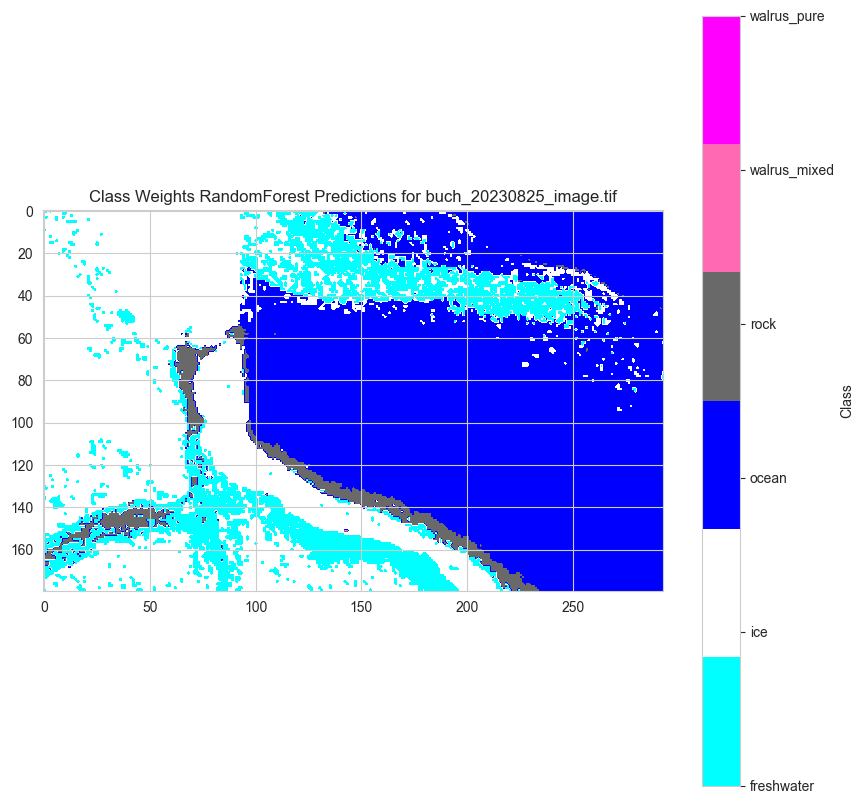

Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


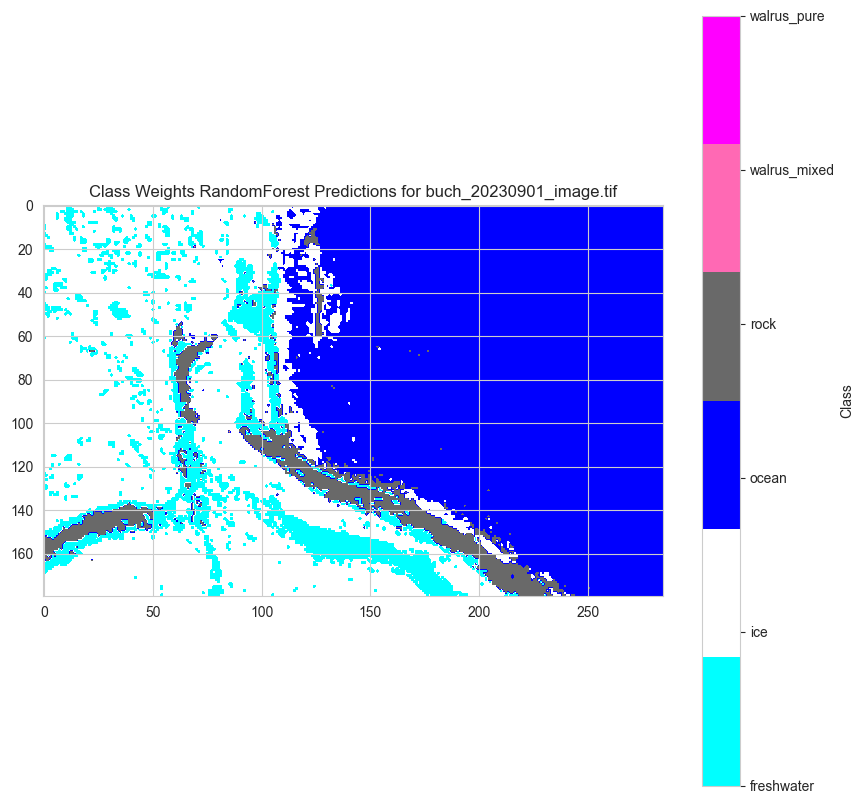

Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


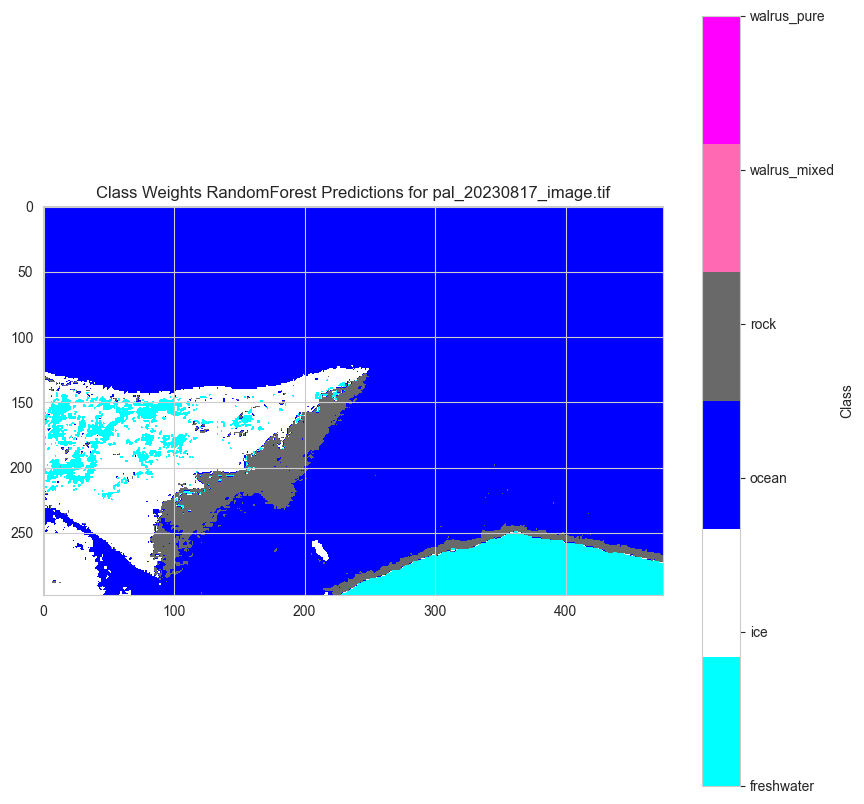

Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


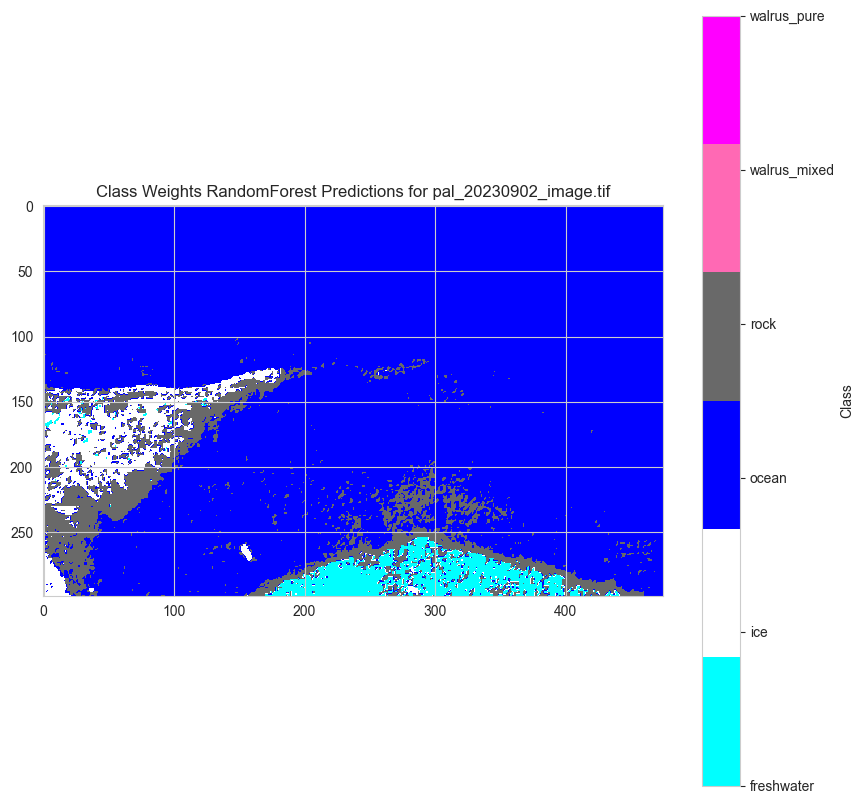

Labels present in sars_20230719_image.tif: ['ice', 'ocean', 'rock']


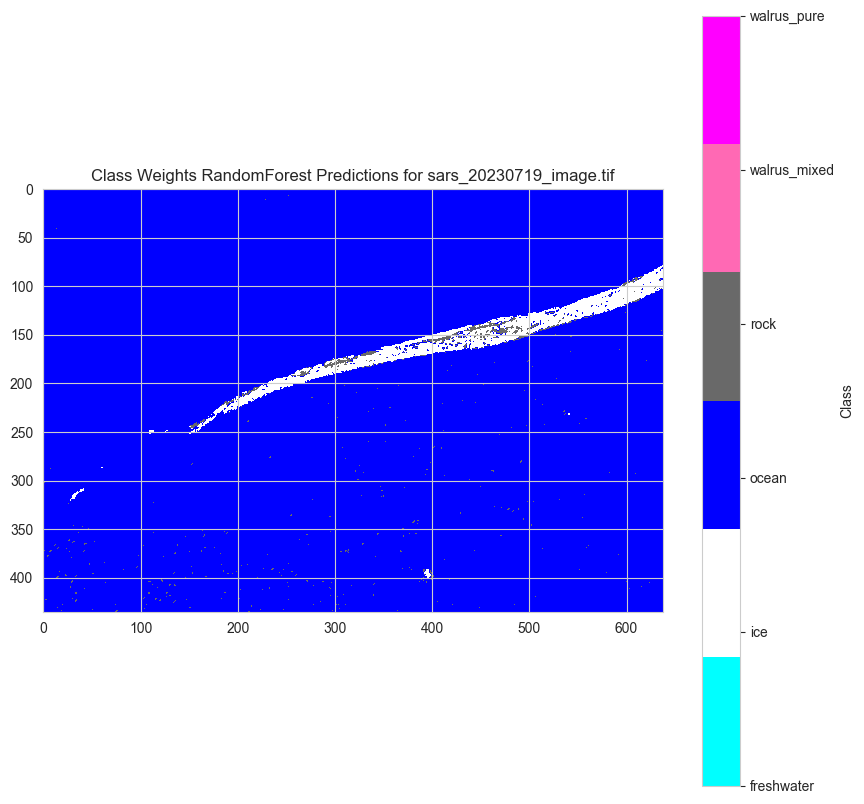

Labels present in sars_20230726.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


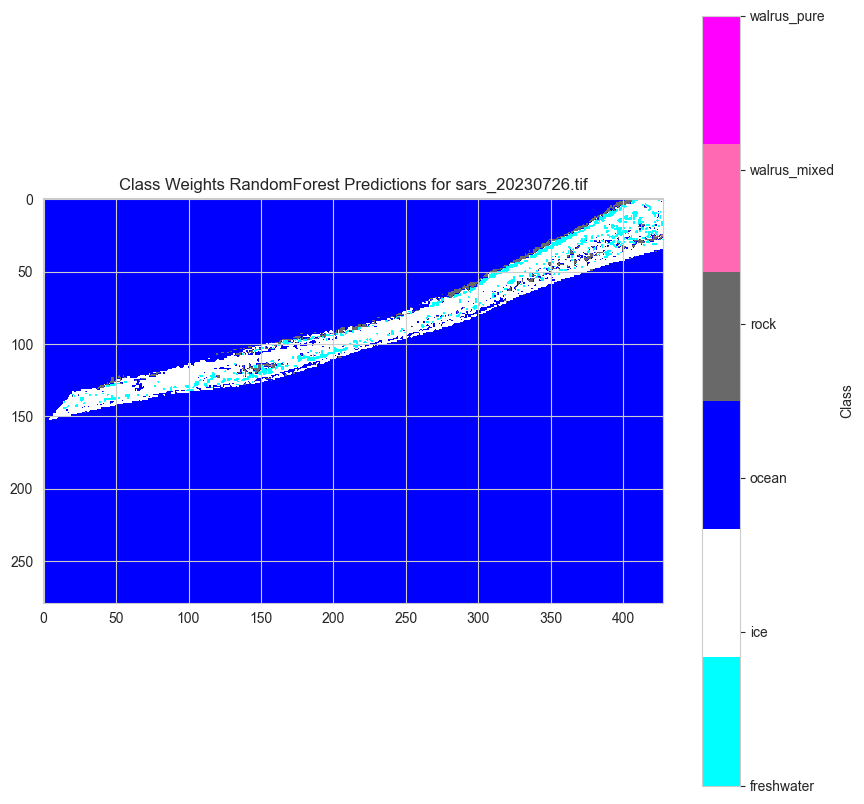

Labels present in sars_20230808_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


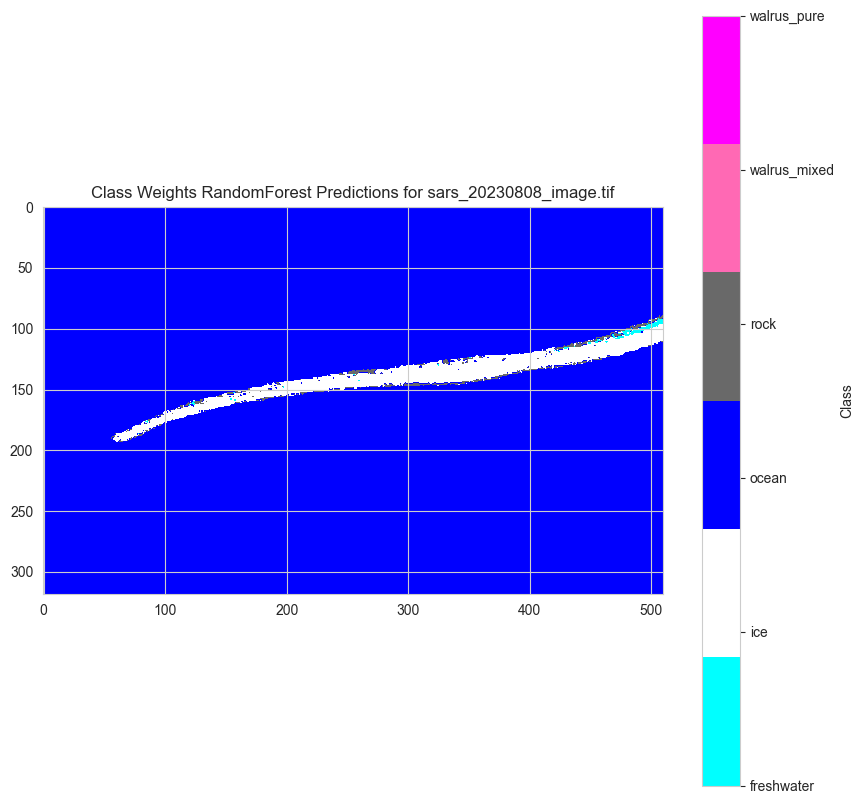

Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


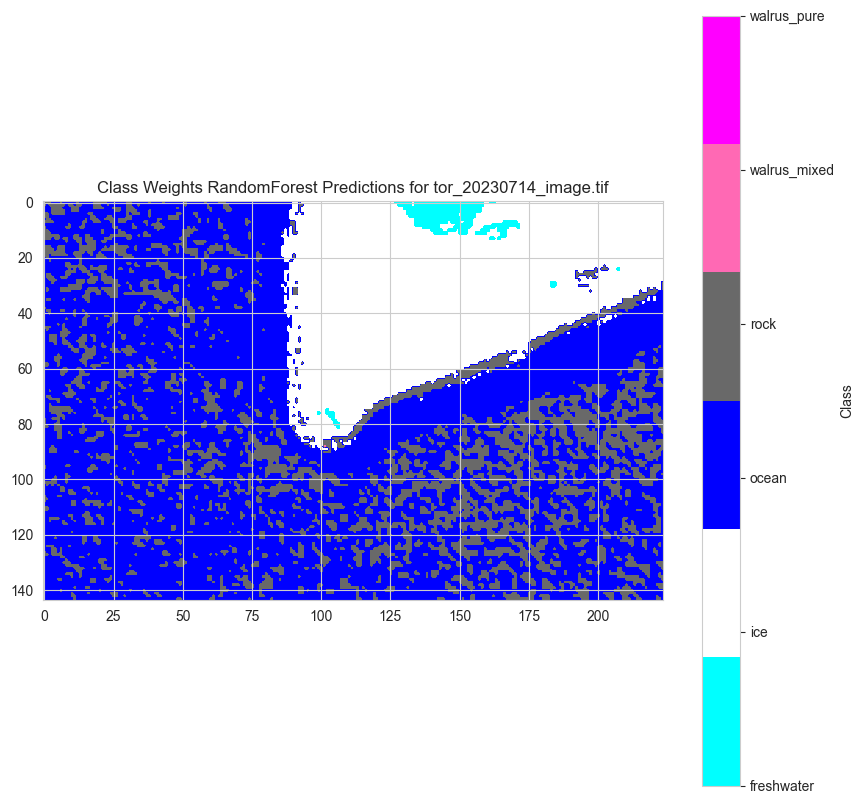

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


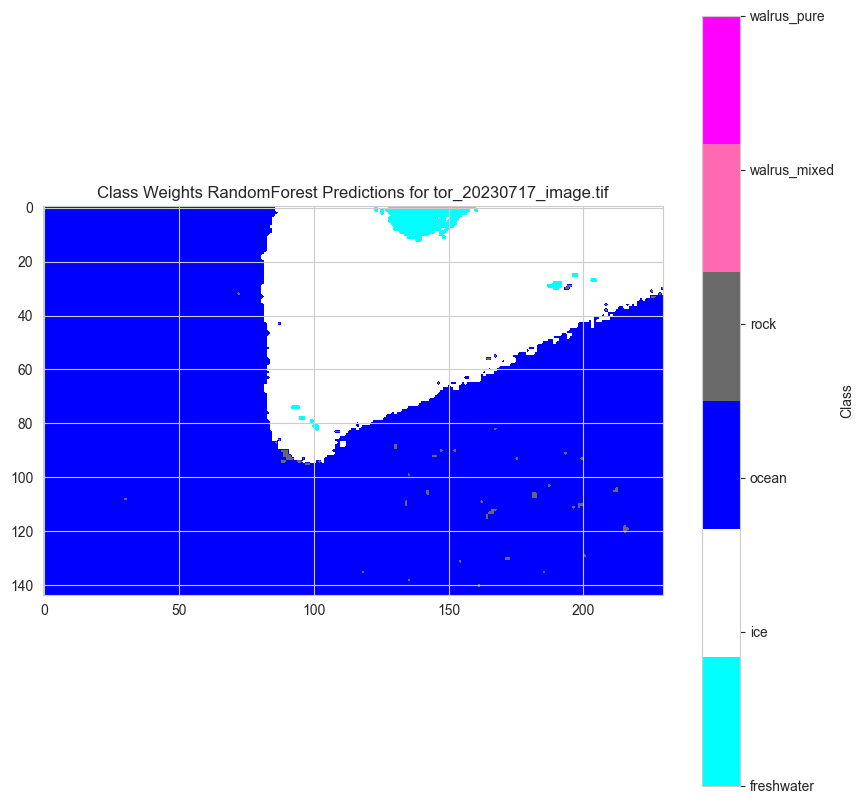

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


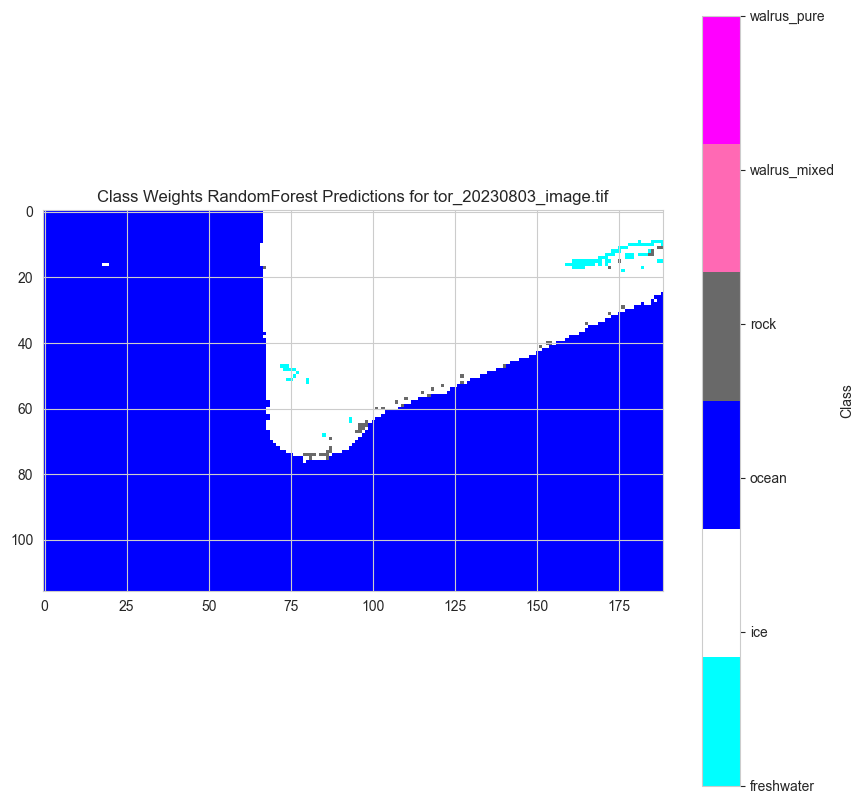

Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


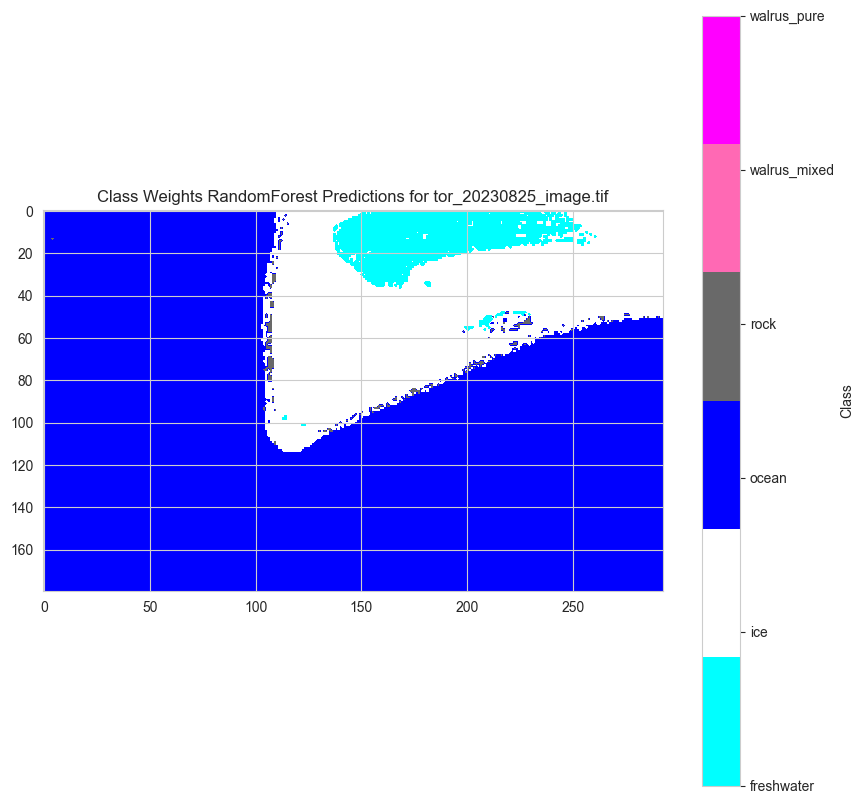

Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


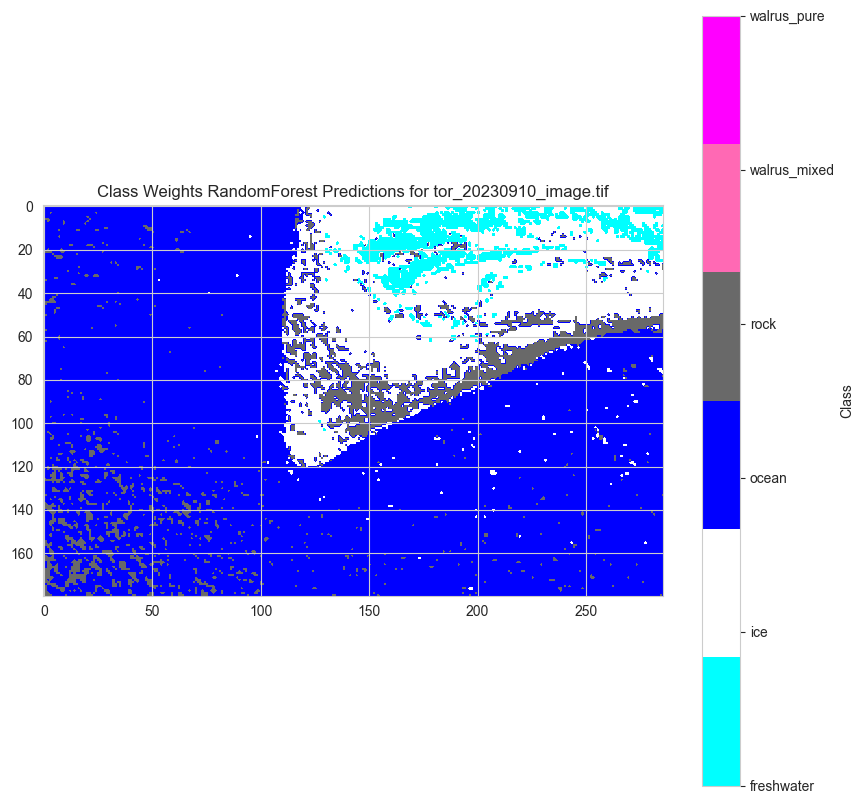

In [16]:
# Predict and plot results
predicted_images_class_weights_rf = {}
for image_path in unlabeled_image_paths:
    predicted_images_class_weights_rf[image_path] = predict_image(image_path, model)

plot_predictions(predicted_images_class_weights_rf, "Class Weights RandomForest Predictions")
